# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

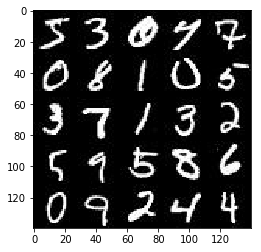

In [236]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import pickle as pkl

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

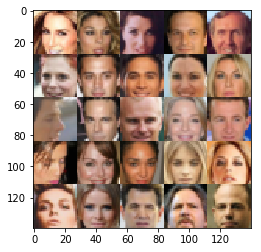

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [143]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels),name='input_real')
    inputs_z = tf.placeholder(tf.float32,(None, z_dim), name='z_dim')
    input_learning_rate = tf.placeholder(tf.float32, name = 'learning_rate') 
    return inputs_real, inputs_z, input_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [223]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input images is 28x28x3
        
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)
        #14 * 14 * 64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7 * 7 * 128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #4 * 4 * 256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
#        print('from dis')
#        print(out)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [224]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator',reuse=not is_train):
        # First fully connected layer
        
        x1 = tf.layers.dense(z, 3*3*256)
        x1 = tf.reshape(x1, (-1, 3, 3, 256))#这里-1是为了自动匹配
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #4* 4 * 256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 3, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #7 * 7 * 128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)    
        #14 * 14 * 64
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        
        out = tf.tanh(logits)    
#        print('from gen')
#        print(out)
    return out 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [225]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    

    g_model = generator(input_z, out_channel_dim=out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(images=input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    
    d_loss = d_loss_real + d_loss_fake
  
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [226]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [227]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [248]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model
#    saver = tf.train.Saver()
#    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
#    saver = tf.train.Saver()
    input_real, input_z, input_learning_rate = model_inputs(image_height=data_shape[1],image_width=data_shape[2], image_channels=data_shape[3], z_dim=z_dim)
    d_loss,g_loss = model_loss(input_real, input_z, out_channel_dim=data_shape[3]) 
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, input_learning_rate, beta1)
    samples, losses = [], []
    steps = 0    

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2     #Generator使用求最后的的英文Tanh激活函数，输出值在-1到1之间，但batch_images的值在-0.5到0.5之间，
                                      #因此需要乘以2，转化为-1到1，即batch_images *= 2。这也是图片发灰的原因。
                
                steps += 1
#                x1 = tf.reshape(x1, (-1, 4, 4, 256))
                #batch_images = np.reshape(batch_images,(batch_size,28,28,1))

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers 
#                print(data_shape)


                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_learning_rate:learning_rate})
                

                if steps % 10 == 0:
                    
                    
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = sess.run(g_loss, {input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(steps+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100  == 0:

                    _ = show_generator_output(sess,image_mode=data_image_mode, input_z=input_z, 
                                                       n_images=12,out_channel_dim=data_shape[3])
                    
            
#        saver.save(sess, './checkpoints/generator.ckpt') 

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples             
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 11/2... Discriminator Loss: 1.1264... Generator Loss: 1.0029
Epoch 21/2... Discriminator Loss: 1.5404... Generator Loss: 3.2462
Epoch 31/2... Discriminator Loss: 2.5227... Generator Loss: 0.1850
Epoch 41/2... Discriminator Loss: 0.6441... Generator Loss: 1.3340
Epoch 51/2... Discriminator Loss: 0.9468... Generator Loss: 1.3818
Epoch 61/2... Discriminator Loss: 1.5303... Generator Loss: 0.3641
Epoch 71/2... Discriminator Loss: 1.5390... Generator Loss: 0.4693
Epoch 81/2... Discriminator Loss: 2.1156... Generator Loss: 0.2114
Epoch 91/2... Discriminator Loss: 0.7289... Generator Loss: 1.3023
Epoch 101/2... Discriminator Loss: 0.9460... Generator Loss: 1.1271


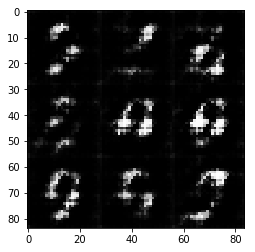

Epoch 111/2... Discriminator Loss: 0.7967... Generator Loss: 0.9390
Epoch 121/2... Discriminator Loss: 0.9780... Generator Loss: 2.1749
Epoch 131/2... Discriminator Loss: 1.3240... Generator Loss: 0.5799
Epoch 141/2... Discriminator Loss: 1.2163... Generator Loss: 0.7244
Epoch 151/2... Discriminator Loss: 2.0172... Generator Loss: 0.3530
Epoch 161/2... Discriminator Loss: 0.7122... Generator Loss: 1.1898
Epoch 171/2... Discriminator Loss: 1.0046... Generator Loss: 1.3080
Epoch 181/2... Discriminator Loss: 0.7353... Generator Loss: 1.9059
Epoch 191/2... Discriminator Loss: 1.4717... Generator Loss: 3.9275
Epoch 201/2... Discriminator Loss: 0.8611... Generator Loss: 1.2835


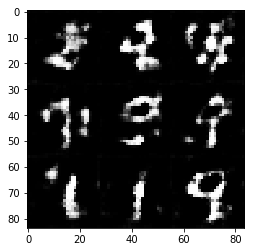

Epoch 211/2... Discriminator Loss: 1.7184... Generator Loss: 0.4514
Epoch 221/2... Discriminator Loss: 1.0348... Generator Loss: 1.0218
Epoch 231/2... Discriminator Loss: 1.4349... Generator Loss: 0.4314
Epoch 241/2... Discriminator Loss: 1.2658... Generator Loss: 0.6167
Epoch 251/2... Discriminator Loss: 1.0523... Generator Loss: 1.1384
Epoch 261/2... Discriminator Loss: 0.7193... Generator Loss: 1.6616
Epoch 271/2... Discriminator Loss: 2.5394... Generator Loss: 0.1521
Epoch 281/2... Discriminator Loss: 1.1063... Generator Loss: 0.5665
Epoch 291/2... Discriminator Loss: 1.3211... Generator Loss: 1.3014
Epoch 301/2... Discriminator Loss: 1.2356... Generator Loss: 0.8427


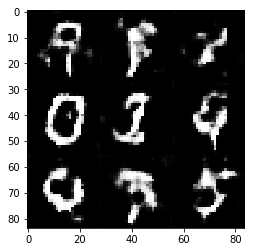

Epoch 311/2... Discriminator Loss: 0.7212... Generator Loss: 1.9099
Epoch 321/2... Discriminator Loss: 1.1862... Generator Loss: 2.1929
Epoch 331/2... Discriminator Loss: 1.0676... Generator Loss: 0.6796
Epoch 341/2... Discriminator Loss: 1.2123... Generator Loss: 0.6580
Epoch 351/2... Discriminator Loss: 0.8311... Generator Loss: 1.8161
Epoch 361/2... Discriminator Loss: 0.9109... Generator Loss: 1.1995
Epoch 371/2... Discriminator Loss: 1.1574... Generator Loss: 0.5914
Epoch 381/2... Discriminator Loss: 1.7503... Generator Loss: 0.3533
Epoch 391/2... Discriminator Loss: 1.1316... Generator Loss: 0.7558
Epoch 401/2... Discriminator Loss: 1.1980... Generator Loss: 1.2018


Epoch 411/2... Discriminator Loss: 0.8117... Generator Loss: 1.4533
Epoch 421/2... Discriminator Loss: 0.8317... Generator Loss: 1.1498
Epoch 431/2... Discriminator Loss: 1.0799... Generator Loss: 1.1363
Epoch 441/2... Discriminator Loss: 0.9080... Generator Loss: 0.8491
Epoch 451/2... Discriminator Loss: 1.0808... Generator Loss: 2.0277
Epoch 461/2... Discriminator Loss: 1.9706... Generator Loss: 0.2324
Epoch 471/2... Discriminator Loss: 0.7689... Generator Loss: 1.4616
Epoch 481/2... Discriminator Loss: 1.0844... Generator Loss: 0.8724
Epoch 491/2... Discriminator Loss: 0.9456... Generator Loss: 1.9670
Epoch 501/2... Discriminator Loss: 0.9680... Generator Loss: 0.9763


Epoch 511/2... Discriminator Loss: 1.3834... Generator Loss: 1.2565
Epoch 521/2... Discriminator Loss: 1.3043... Generator Loss: 0.5639
Epoch 531/2... Discriminator Loss: 0.9868... Generator Loss: 0.8645
Epoch 541/2... Discriminator Loss: 0.9469... Generator Loss: 1.1906
Epoch 551/2... Discriminator Loss: 2.5224... Generator Loss: 4.0554
Epoch 561/2... Discriminator Loss: 1.3579... Generator Loss: 0.5208
Epoch 571/2... Discriminator Loss: 1.1208... Generator Loss: 1.1510
Epoch 581/2... Discriminator Loss: 0.9216... Generator Loss: 0.8633
Epoch 591/2... Discriminator Loss: 0.9498... Generator Loss: 0.9475
Epoch 601/2... Discriminator Loss: 1.3540... Generator Loss: 0.4376


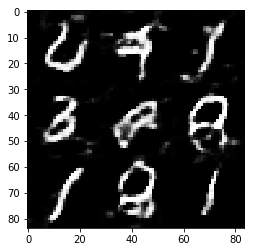

Epoch 611/2... Discriminator Loss: 1.0349... Generator Loss: 1.3295
Epoch 621/2... Discriminator Loss: 0.9878... Generator Loss: 0.8374
Epoch 631/2... Discriminator Loss: 1.0553... Generator Loss: 0.7120
Epoch 641/2... Discriminator Loss: 1.1704... Generator Loss: 0.5955
Epoch 651/2... Discriminator Loss: 0.9479... Generator Loss: 1.2850
Epoch 661/2... Discriminator Loss: 1.1594... Generator Loss: 0.6073
Epoch 671/2... Discriminator Loss: 1.0427... Generator Loss: 0.9455
Epoch 681/2... Discriminator Loss: 1.0090... Generator Loss: 1.0188
Epoch 691/2... Discriminator Loss: 0.9995... Generator Loss: 0.8369
Epoch 701/2... Discriminator Loss: 0.9459... Generator Loss: 1.8447


Epoch 711/2... Discriminator Loss: 1.3963... Generator Loss: 0.4960
Epoch 721/2... Discriminator Loss: 1.2017... Generator Loss: 0.7755
Epoch 731/2... Discriminator Loss: 0.7856... Generator Loss: 1.3725
Epoch 741/2... Discriminator Loss: 1.4665... Generator Loss: 2.6078
Epoch 751/2... Discriminator Loss: 1.1445... Generator Loss: 0.5677
Epoch 761/2... Discriminator Loss: 1.0547... Generator Loss: 0.8449
Epoch 771/2... Discriminator Loss: 0.8409... Generator Loss: 1.4148
Epoch 781/2... Discriminator Loss: 1.6662... Generator Loss: 0.3520
Epoch 791/2... Discriminator Loss: 1.0748... Generator Loss: 0.6853
Epoch 801/2... Discriminator Loss: 1.1667... Generator Loss: 1.1395


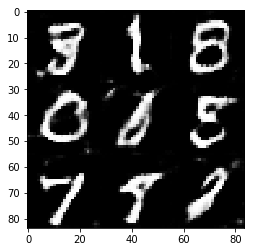

Epoch 811/2... Discriminator Loss: 0.9676... Generator Loss: 0.7358
Epoch 821/2... Discriminator Loss: 1.0844... Generator Loss: 1.1635
Epoch 831/2... Discriminator Loss: 1.5861... Generator Loss: 0.3582
Epoch 841/2... Discriminator Loss: 0.6979... Generator Loss: 1.1749
Epoch 851/2... Discriminator Loss: 0.6776... Generator Loss: 1.1357
Epoch 861/2... Discriminator Loss: 2.5274... Generator Loss: 0.1638
Epoch 871/2... Discriminator Loss: 1.2978... Generator Loss: 1.7035
Epoch 881/2... Discriminator Loss: 1.1965... Generator Loss: 0.5673
Epoch 891/2... Discriminator Loss: 0.7407... Generator Loss: 1.4100
Epoch 901/2... Discriminator Loss: 0.8013... Generator Loss: 1.2534


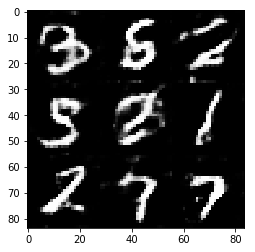

Epoch 911/2... Discriminator Loss: 1.0211... Generator Loss: 0.8757
Epoch 921/2... Discriminator Loss: 1.1115... Generator Loss: 0.7158
Epoch 931/2... Discriminator Loss: 0.7986... Generator Loss: 1.1402
Epoch 941/2... Discriminator Loss: 1.3930... Generator Loss: 0.5049
Epoch 951/2... Discriminator Loss: 0.7820... Generator Loss: 1.3444
Epoch 961/2... Discriminator Loss: 0.9573... Generator Loss: 0.8031
Epoch 971/2... Discriminator Loss: 0.7250... Generator Loss: 1.4423
Epoch 981/2... Discriminator Loss: 0.9636... Generator Loss: 1.4361
Epoch 991/2... Discriminator Loss: 0.7694... Generator Loss: 1.6235
Epoch 1001/2... Discriminator Loss: 0.8773... Generator Loss: 1.0529


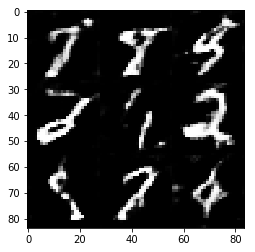

Epoch 1011/2... Discriminator Loss: 0.9194... Generator Loss: 1.0185
Epoch 1021/2... Discriminator Loss: 0.7690... Generator Loss: 1.1257
Epoch 1031/2... Discriminator Loss: 1.1408... Generator Loss: 2.2980
Epoch 1041/2... Discriminator Loss: 1.1184... Generator Loss: 1.1897
Epoch 1051/2... Discriminator Loss: 0.8299... Generator Loss: 2.4762
Epoch 1061/2... Discriminator Loss: 0.9291... Generator Loss: 0.8271
Epoch 1071/2... Discriminator Loss: 0.9659... Generator Loss: 1.1558
Epoch 1081/2... Discriminator Loss: 1.0998... Generator Loss: 0.7431
Epoch 1091/2... Discriminator Loss: 0.8504... Generator Loss: 0.9505
Epoch 1101/2... Discriminator Loss: 0.8130... Generator Loss: 2.5858


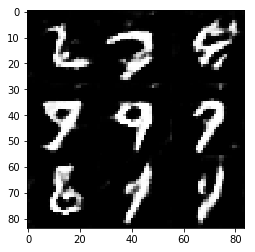

Epoch 1111/2... Discriminator Loss: 0.9638... Generator Loss: 0.9548
Epoch 1121/2... Discriminator Loss: 3.1216... Generator Loss: 0.1132
Epoch 1131/2... Discriminator Loss: 0.7795... Generator Loss: 1.2691
Epoch 1141/2... Discriminator Loss: 0.8537... Generator Loss: 1.1128
Epoch 1151/2... Discriminator Loss: 0.8340... Generator Loss: 1.0551
Epoch 1161/2... Discriminator Loss: 0.7410... Generator Loss: 2.0801
Epoch 1171/2... Discriminator Loss: 1.3060... Generator Loss: 0.5206
Epoch 1181/2... Discriminator Loss: 1.1569... Generator Loss: 0.6008
Epoch 1191/2... Discriminator Loss: 1.3477... Generator Loss: 0.4906
Epoch 1201/2... Discriminator Loss: 0.8935... Generator Loss: 0.9114


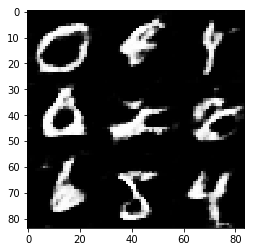

Epoch 1211/2... Discriminator Loss: 1.0053... Generator Loss: 0.7935
Epoch 1221/2... Discriminator Loss: 1.0908... Generator Loss: 0.5963
Epoch 1231/2... Discriminator Loss: 1.5719... Generator Loss: 0.4153
Epoch 1241/2... Discriminator Loss: 0.7998... Generator Loss: 1.0180
Epoch 1251/2... Discriminator Loss: 0.9521... Generator Loss: 0.7910
Epoch 1261/2... Discriminator Loss: 1.6004... Generator Loss: 2.8684
Epoch 1271/2... Discriminator Loss: 2.1004... Generator Loss: 0.3115
Epoch 1281/2... Discriminator Loss: 0.9655... Generator Loss: 1.2528
Epoch 1291/2... Discriminator Loss: 0.5802... Generator Loss: 1.3786
Epoch 1301/2... Discriminator Loss: 2.0310... Generator Loss: 3.9288


Epoch 1311/2... Discriminator Loss: 1.1509... Generator Loss: 0.5872
Epoch 1321/2... Discriminator Loss: 1.0306... Generator Loss: 1.5527
Epoch 1331/2... Discriminator Loss: 1.0693... Generator Loss: 2.0438
Epoch 1341/2... Discriminator Loss: 1.4432... Generator Loss: 2.6202
Epoch 1351/2... Discriminator Loss: 1.5279... Generator Loss: 0.5264
Epoch 1361/2... Discriminator Loss: 0.7150... Generator Loss: 1.2170
Epoch 1371/2... Discriminator Loss: 0.9638... Generator Loss: 0.7675
Epoch 1381/2... Discriminator Loss: 1.8602... Generator Loss: 0.5024
Epoch 1391/2... Discriminator Loss: 0.8630... Generator Loss: 0.8900
Epoch 1401/2... Discriminator Loss: 1.0493... Generator Loss: 2.1093


Epoch 1411/2... Discriminator Loss: 0.9539... Generator Loss: 0.8425
Epoch 1421/2... Discriminator Loss: 0.7035... Generator Loss: 2.1131
Epoch 1431/2... Discriminator Loss: 1.7329... Generator Loss: 0.4324
Epoch 1441/2... Discriminator Loss: 0.7129... Generator Loss: 1.6824
Epoch 1451/2... Discriminator Loss: 1.0718... Generator Loss: 1.7931
Epoch 1461/2... Discriminator Loss: 0.7519... Generator Loss: 1.3075
Epoch 1471/2... Discriminator Loss: 0.7047... Generator Loss: 1.5164
Epoch 1481/2... Discriminator Loss: 0.9333... Generator Loss: 0.7765
Epoch 1491/2... Discriminator Loss: 0.6981... Generator Loss: 1.2182
Epoch 1501/2... Discriminator Loss: 0.6997... Generator Loss: 3.0346


Epoch 1511/2... Discriminator Loss: 1.0242... Generator Loss: 0.8064
Epoch 1521/2... Discriminator Loss: 0.7604... Generator Loss: 1.5303
Epoch 1531/2... Discriminator Loss: 0.5870... Generator Loss: 1.3699
Epoch 1541/2... Discriminator Loss: 0.6072... Generator Loss: 1.3552
Epoch 1551/2... Discriminator Loss: 1.7917... Generator Loss: 0.3705
Epoch 1561/2... Discriminator Loss: 0.7212... Generator Loss: 1.7966
Epoch 1571/2... Discriminator Loss: 1.0252... Generator Loss: 0.8832
Epoch 1581/2... Discriminator Loss: 0.7189... Generator Loss: 1.1796
Epoch 1591/2... Discriminator Loss: 1.1830... Generator Loss: 0.6218
Epoch 1601/2... Discriminator Loss: 1.2793... Generator Loss: 0.5034


Epoch 1611/2... Discriminator Loss: 1.3982... Generator Loss: 0.5379
Epoch 1621/2... Discriminator Loss: 0.6040... Generator Loss: 1.8905
Epoch 1631/2... Discriminator Loss: 1.1467... Generator Loss: 3.0248
Epoch 1641/2... Discriminator Loss: 0.7154... Generator Loss: 1.4257
Epoch 1651/2... Discriminator Loss: 0.7927... Generator Loss: 1.1366
Epoch 1661/2... Discriminator Loss: 0.7777... Generator Loss: 1.8623
Epoch 1671/2... Discriminator Loss: 1.1505... Generator Loss: 0.7284
Epoch 1681/2... Discriminator Loss: 0.4973... Generator Loss: 1.8756
Epoch 1691/2... Discriminator Loss: 0.7241... Generator Loss: 1.2819
Epoch 1701/2... Discriminator Loss: 1.3864... Generator Loss: 0.4421


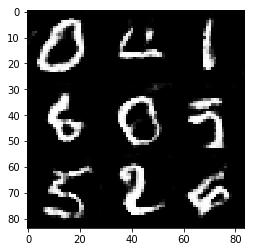

Epoch 1711/2... Discriminator Loss: 1.3222... Generator Loss: 0.5406
Epoch 1721/2... Discriminator Loss: 1.8845... Generator Loss: 0.3035
Epoch 1731/2... Discriminator Loss: 0.8793... Generator Loss: 1.0048
Epoch 1741/2... Discriminator Loss: 0.7308... Generator Loss: 1.0049
Epoch 1751/2... Discriminator Loss: 0.8564... Generator Loss: 0.9020
Epoch 1761/2... Discriminator Loss: 0.6632... Generator Loss: 1.1960
Epoch 1771/2... Discriminator Loss: 0.7896... Generator Loss: 1.0376
Epoch 1781/2... Discriminator Loss: 0.8595... Generator Loss: 0.9953
Epoch 1791/2... Discriminator Loss: 0.5319... Generator Loss: 1.5579
Epoch 1801/2... Discriminator Loss: 1.3672... Generator Loss: 0.7520


Epoch 1811/2... Discriminator Loss: 1.0459... Generator Loss: 0.9455
Epoch 1821/2... Discriminator Loss: 1.0557... Generator Loss: 0.6208
Epoch 1831/2... Discriminator Loss: 1.4373... Generator Loss: 0.4700
Epoch 1841/2... Discriminator Loss: 1.3561... Generator Loss: 0.5025
Epoch 1851/2... Discriminator Loss: 1.3070... Generator Loss: 3.1378
Epoch 1861/2... Discriminator Loss: 0.8873... Generator Loss: 0.8881
Epoch 1871/2... Discriminator Loss: 1.1487... Generator Loss: 0.6282


In [249]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5
#image_width =  28
#image_height = 28
#image_channels = 1
alpha = 0.2
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 11/1... Discriminator Loss: 0.1138... Generator Loss: 2.4710
Epoch 21/1... Discriminator Loss: 0.1148... Generator Loss: 2.7839
Epoch 31/1... Discriminator Loss: 0.0690... Generator Loss: 3.1625
Epoch 41/1... Discriminator Loss: 0.1955... Generator Loss: 1.9672
Epoch 51/1... Discriminator Loss: 0.0506... Generator Loss: 3.6753
Epoch 61/1... Discriminator Loss: 0.0256... Generator Loss: 5.4789
Epoch 71/1... Discriminator Loss: 0.0429... Generator Loss: 8.3729
Epoch 81/1... Discriminator Loss: 3.8967... Generator Loss: 0.0804
Epoch 91/1... Discriminator Loss: 1.3679... Generator Loss: 0.7464
Epoch 101/1... Discriminator Loss: 0.0860... Generator Loss: 2.9697


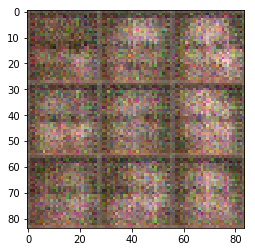

Epoch 111/1... Discriminator Loss: 0.2783... Generator Loss: 6.7458
Epoch 121/1... Discriminator Loss: 0.3434... Generator Loss: 1.6539
Epoch 131/1... Discriminator Loss: 1.0372... Generator Loss: 0.8824
Epoch 141/1... Discriminator Loss: 0.2092... Generator Loss: 3.0895
Epoch 151/1... Discriminator Loss: 0.1459... Generator Loss: 3.8534
Epoch 161/1... Discriminator Loss: 1.8582... Generator Loss: 0.2940
Epoch 171/1... Discriminator Loss: 0.0532... Generator Loss: 3.4523
Epoch 181/1... Discriminator Loss: 0.2890... Generator Loss: 2.4346
Epoch 191/1... Discriminator Loss: 0.0898... Generator Loss: 5.8577
Epoch 201/1... Discriminator Loss: 0.0798... Generator Loss: 3.0910


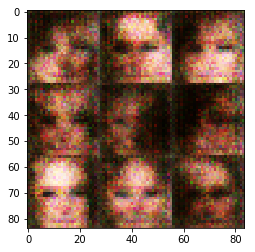

Epoch 211/1... Discriminator Loss: 0.1502... Generator Loss: 2.3326
Epoch 221/1... Discriminator Loss: 0.1455... Generator Loss: 2.5968
Epoch 231/1... Discriminator Loss: 0.0928... Generator Loss: 3.0765
Epoch 241/1... Discriminator Loss: 0.1311... Generator Loss: 3.1693
Epoch 251/1... Discriminator Loss: 0.1600... Generator Loss: 2.4780
Epoch 261/1... Discriminator Loss: 0.1462... Generator Loss: 3.4291
Epoch 271/1... Discriminator Loss: 0.3241... Generator Loss: 2.0983
Epoch 281/1... Discriminator Loss: 1.0006... Generator Loss: 8.0082
Epoch 291/1... Discriminator Loss: 0.2586... Generator Loss: 2.1275
Epoch 301/1... Discriminator Loss: 0.0865... Generator Loss: 6.1848


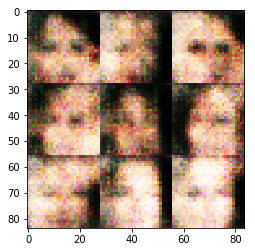

Epoch 311/1... Discriminator Loss: 0.0653... Generator Loss: 4.9691
Epoch 321/1... Discriminator Loss: 0.3655... Generator Loss: 1.6350
Epoch 331/1... Discriminator Loss: 0.3553... Generator Loss: 2.6796
Epoch 341/1... Discriminator Loss: 0.2781... Generator Loss: 2.0258
Epoch 351/1... Discriminator Loss: 0.1165... Generator Loss: 3.2541
Epoch 361/1... Discriminator Loss: 0.4601... Generator Loss: 1.5770
Epoch 371/1... Discriminator Loss: 1.0900... Generator Loss: 1.1634
Epoch 381/1... Discriminator Loss: 0.5971... Generator Loss: 1.9441
Epoch 391/1... Discriminator Loss: 1.0934... Generator Loss: 0.6967
Epoch 401/1... Discriminator Loss: 0.5669... Generator Loss: 1.2842


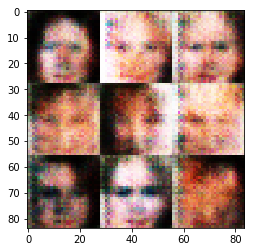

Epoch 411/1... Discriminator Loss: 0.1445... Generator Loss: 2.9900
Epoch 421/1... Discriminator Loss: 0.2270... Generator Loss: 3.0127
Epoch 431/1... Discriminator Loss: 0.3045... Generator Loss: 2.0749
Epoch 441/1... Discriminator Loss: 0.6701... Generator Loss: 0.9022
Epoch 451/1... Discriminator Loss: 0.5073... Generator Loss: 1.7355
Epoch 461/1... Discriminator Loss: 0.1457... Generator Loss: 2.4830
Epoch 471/1... Discriminator Loss: 0.2656... Generator Loss: 2.5371
Epoch 481/1... Discriminator Loss: 0.1496... Generator Loss: 2.9690
Epoch 491/1... Discriminator Loss: 0.1270... Generator Loss: 4.4122
Epoch 501/1... Discriminator Loss: 0.3075... Generator Loss: 2.0055


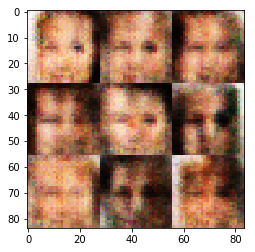

Epoch 511/1... Discriminator Loss: 1.7319... Generator Loss: 0.4248
Epoch 521/1... Discriminator Loss: 0.4109... Generator Loss: 3.6591
Epoch 531/1... Discriminator Loss: 1.1889... Generator Loss: 0.8110
Epoch 541/1... Discriminator Loss: 0.1853... Generator Loss: 2.7784
Epoch 551/1... Discriminator Loss: 0.1615... Generator Loss: 5.3310
Epoch 561/1... Discriminator Loss: 0.4663... Generator Loss: 1.3432
Epoch 571/1... Discriminator Loss: 0.9410... Generator Loss: 0.8721
Epoch 581/1... Discriminator Loss: 0.3930... Generator Loss: 3.3634
Epoch 591/1... Discriminator Loss: 0.5974... Generator Loss: 1.4684
Epoch 601/1... Discriminator Loss: 0.4984... Generator Loss: 1.2399


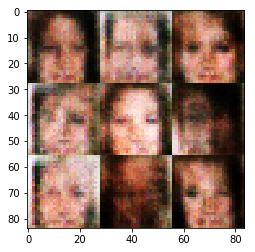

Epoch 611/1... Discriminator Loss: 0.4435... Generator Loss: 2.1757
Epoch 621/1... Discriminator Loss: 0.3871... Generator Loss: 1.6707
Epoch 631/1... Discriminator Loss: 0.2661... Generator Loss: 2.2287
Epoch 641/1... Discriminator Loss: 0.2081... Generator Loss: 2.6055
Epoch 651/1... Discriminator Loss: 0.5050... Generator Loss: 1.4463
Epoch 661/1... Discriminator Loss: 0.2560... Generator Loss: 2.8122
Epoch 671/1... Discriminator Loss: 0.4518... Generator Loss: 1.6254
Epoch 681/1... Discriminator Loss: 0.8358... Generator Loss: 0.7369
Epoch 691/1... Discriminator Loss: 0.4099... Generator Loss: 1.2858
Epoch 701/1... Discriminator Loss: 0.3039... Generator Loss: 2.3422


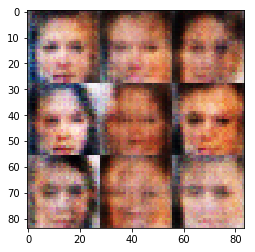

Epoch 711/1... Discriminator Loss: 0.3244... Generator Loss: 5.9554
Epoch 721/1... Discriminator Loss: 0.8135... Generator Loss: 1.2260
Epoch 731/1... Discriminator Loss: 0.7722... Generator Loss: 1.2056
Epoch 741/1... Discriminator Loss: 0.2484... Generator Loss: 2.5135
Epoch 751/1... Discriminator Loss: 0.7613... Generator Loss: 1.0232
Epoch 761/1... Discriminator Loss: 0.3626... Generator Loss: 1.7390
Epoch 771/1... Discriminator Loss: 0.1707... Generator Loss: 3.6269
Epoch 781/1... Discriminator Loss: 0.1922... Generator Loss: 2.6559
Epoch 791/1... Discriminator Loss: 0.3929... Generator Loss: 1.8527
Epoch 801/1... Discriminator Loss: 0.7085... Generator Loss: 5.0417


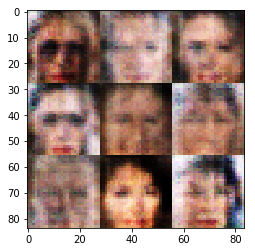

Epoch 811/1... Discriminator Loss: 0.3956... Generator Loss: 2.6200
Epoch 821/1... Discriminator Loss: 0.8033... Generator Loss: 0.7945
Epoch 831/1... Discriminator Loss: 0.2565... Generator Loss: 2.7489
Epoch 841/1... Discriminator Loss: 0.2205... Generator Loss: 3.3190
Epoch 851/1... Discriminator Loss: 0.2616... Generator Loss: 2.4070
Epoch 861/1... Discriminator Loss: 0.6459... Generator Loss: 5.0504
Epoch 871/1... Discriminator Loss: 0.4617... Generator Loss: 1.6730
Epoch 881/1... Discriminator Loss: 0.2264... Generator Loss: 2.5235
Epoch 891/1... Discriminator Loss: 0.4309... Generator Loss: 2.0068
Epoch 901/1... Discriminator Loss: 0.4449... Generator Loss: 1.3462


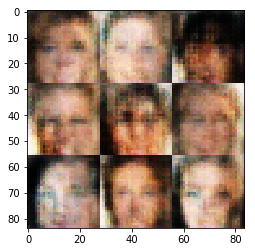

Epoch 911/1... Discriminator Loss: 0.8062... Generator Loss: 1.2207
Epoch 921/1... Discriminator Loss: 0.6795... Generator Loss: 4.6017
Epoch 931/1... Discriminator Loss: 0.4602... Generator Loss: 1.6516
Epoch 941/1... Discriminator Loss: 0.5603... Generator Loss: 2.3873
Epoch 951/1... Discriminator Loss: 0.2901... Generator Loss: 2.8926
Epoch 961/1... Discriminator Loss: 0.5806... Generator Loss: 1.2738
Epoch 971/1... Discriminator Loss: 0.5653... Generator Loss: 1.2288
Epoch 981/1... Discriminator Loss: 0.3796... Generator Loss: 1.8186
Epoch 991/1... Discriminator Loss: 0.4197... Generator Loss: 1.9048
Epoch 1001/1... Discriminator Loss: 0.5387... Generator Loss: 1.3033


Epoch 1011/1... Discriminator Loss: 0.3606... Generator Loss: 2.1234
Epoch 1021/1... Discriminator Loss: 0.4071... Generator Loss: 2.1575
Epoch 1031/1... Discriminator Loss: 0.7823... Generator Loss: 3.1389
Epoch 1041/1... Discriminator Loss: 0.3999... Generator Loss: 1.6798
Epoch 1051/1... Discriminator Loss: 0.4139... Generator Loss: 1.6498
Epoch 1061/1... Discriminator Loss: 0.4356... Generator Loss: 1.4575
Epoch 1071/1... Discriminator Loss: 0.9866... Generator Loss: 0.7201
Epoch 1081/1... Discriminator Loss: 0.3986... Generator Loss: 1.5330
Epoch 1091/1... Discriminator Loss: 0.2833... Generator Loss: 2.3793
Epoch 1101/1... Discriminator Loss: 0.5788... Generator Loss: 3.0860


Epoch 1111/1... Discriminator Loss: 0.5623... Generator Loss: 1.2927
Epoch 1121/1... Discriminator Loss: 0.3722... Generator Loss: 2.0378
Epoch 1131/1... Discriminator Loss: 0.4901... Generator Loss: 1.3463
Epoch 1141/1... Discriminator Loss: 2.0401... Generator Loss: 0.2040
Epoch 1151/1... Discriminator Loss: 0.6128... Generator Loss: 3.6380
Epoch 1161/1... Discriminator Loss: 0.4156... Generator Loss: 1.4691
Epoch 1171/1... Discriminator Loss: 0.7418... Generator Loss: 0.9040
Epoch 1181/1... Discriminator Loss: 0.7341... Generator Loss: 0.8934
Epoch 1191/1... Discriminator Loss: 0.3482... Generator Loss: 1.6160
Epoch 1201/1... Discriminator Loss: 0.3116... Generator Loss: 1.7955


Epoch 1211/1... Discriminator Loss: 0.4741... Generator Loss: 1.7047
Epoch 1221/1... Discriminator Loss: 0.8055... Generator Loss: 0.8193
Epoch 1231/1... Discriminator Loss: 0.3966... Generator Loss: 3.4096
Epoch 1241/1... Discriminator Loss: 0.4490... Generator Loss: 1.5729
Epoch 1251/1... Discriminator Loss: 0.5837... Generator Loss: 1.2839
Epoch 1261/1... Discriminator Loss: 0.4416... Generator Loss: 1.5501
Epoch 1271/1... Discriminator Loss: 0.4128... Generator Loss: 2.1673
Epoch 1281/1... Discriminator Loss: 0.3272... Generator Loss: 2.5462
Epoch 1291/1... Discriminator Loss: 0.3404... Generator Loss: 1.8139
Epoch 1301/1... Discriminator Loss: 0.7024... Generator Loss: 3.7616


Epoch 1311/1... Discriminator Loss: 0.5926... Generator Loss: 2.5635
Epoch 1321/1... Discriminator Loss: 0.2588... Generator Loss: 1.9765
Epoch 1331/1... Discriminator Loss: 0.2731... Generator Loss: 2.2429
Epoch 1341/1... Discriminator Loss: 0.3429... Generator Loss: 1.5910
Epoch 1351/1... Discriminator Loss: 0.4163... Generator Loss: 1.3896
Epoch 1361/1... Discriminator Loss: 0.4381... Generator Loss: 2.0324
Epoch 1371/1... Discriminator Loss: 0.7547... Generator Loss: 2.5908
Epoch 1381/1... Discriminator Loss: 0.5676... Generator Loss: 2.5287
Epoch 1391/1... Discriminator Loss: 0.6337... Generator Loss: 1.2505
Epoch 1401/1... Discriminator Loss: 0.3644... Generator Loss: 1.9961


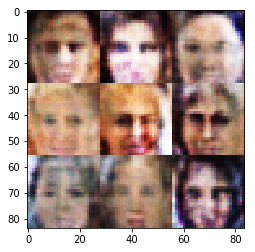

Epoch 1411/1... Discriminator Loss: 0.5717... Generator Loss: 1.0252
Epoch 1421/1... Discriminator Loss: 0.5247... Generator Loss: 1.2605
Epoch 1431/1... Discriminator Loss: 0.3861... Generator Loss: 1.7806
Epoch 1441/1... Discriminator Loss: 0.3061... Generator Loss: 2.1295
Epoch 1451/1... Discriminator Loss: 0.3832... Generator Loss: 1.5904
Epoch 1461/1... Discriminator Loss: 0.7597... Generator Loss: 0.7738
Epoch 1471/1... Discriminator Loss: 0.7255... Generator Loss: 0.9419
Epoch 1481/1... Discriminator Loss: 0.4770... Generator Loss: 3.5603
Epoch 1491/1... Discriminator Loss: 0.4259... Generator Loss: 1.5262
Epoch 1501/1... Discriminator Loss: 0.3784... Generator Loss: 1.6505


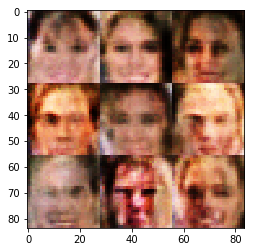

Epoch 1511/1... Discriminator Loss: 0.2734... Generator Loss: 2.3025
Epoch 1521/1... Discriminator Loss: 0.3480... Generator Loss: 2.1777
Epoch 1531/1... Discriminator Loss: 0.5642... Generator Loss: 1.0800
Epoch 1541/1... Discriminator Loss: 0.6131... Generator Loss: 1.5519
Epoch 1551/1... Discriminator Loss: 0.3287... Generator Loss: 2.0618
Epoch 1561/1... Discriminator Loss: 0.6234... Generator Loss: 2.3489
Epoch 1571/1... Discriminator Loss: 0.6279... Generator Loss: 3.6896
Epoch 1581/1... Discriminator Loss: 0.3971... Generator Loss: 1.5188
Epoch 1591/1... Discriminator Loss: 0.2942... Generator Loss: 2.2676
Epoch 1601/1... Discriminator Loss: 0.4878... Generator Loss: 1.4197


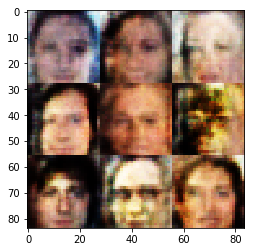

Epoch 1611/1... Discriminator Loss: 0.6288... Generator Loss: 1.0956
Epoch 1621/1... Discriminator Loss: 0.3893... Generator Loss: 1.4580
Epoch 1631/1... Discriminator Loss: 0.7661... Generator Loss: 0.7515
Epoch 1641/1... Discriminator Loss: 0.6648... Generator Loss: 0.8932
Epoch 1651/1... Discriminator Loss: 0.3600... Generator Loss: 1.6866
Epoch 1661/1... Discriminator Loss: 0.3925... Generator Loss: 2.1201
Epoch 1671/1... Discriminator Loss: 0.6763... Generator Loss: 0.9385
Epoch 1681/1... Discriminator Loss: 0.7462... Generator Loss: 0.9358
Epoch 1691/1... Discriminator Loss: 0.6252... Generator Loss: 1.0937
Epoch 1701/1... Discriminator Loss: 0.1863... Generator Loss: 2.4264


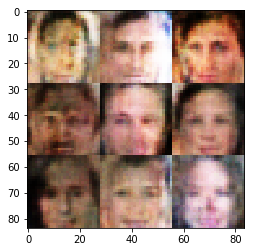

Epoch 1711/1... Discriminator Loss: 0.4235... Generator Loss: 1.6404
Epoch 1721/1... Discriminator Loss: 0.3206... Generator Loss: 2.1123
Epoch 1731/1... Discriminator Loss: 0.7012... Generator Loss: 0.8904
Epoch 1741/1... Discriminator Loss: 0.5385... Generator Loss: 1.1441
Epoch 1751/1... Discriminator Loss: 0.5097... Generator Loss: 1.5922
Epoch 1761/1... Discriminator Loss: 0.6587... Generator Loss: 1.2240
Epoch 1771/1... Discriminator Loss: 0.4185... Generator Loss: 1.7851
Epoch 1781/1... Discriminator Loss: 0.4785... Generator Loss: 1.5234
Epoch 1791/1... Discriminator Loss: 0.4132... Generator Loss: 1.8339
Epoch 1801/1... Discriminator Loss: 0.2554... Generator Loss: 2.0299


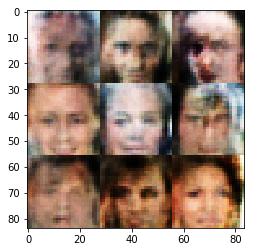

Epoch 1811/1... Discriminator Loss: 0.4695... Generator Loss: 1.5024
Epoch 1821/1... Discriminator Loss: 0.5436... Generator Loss: 3.4723
Epoch 1831/1... Discriminator Loss: 0.5065... Generator Loss: 3.0856
Epoch 1841/1... Discriminator Loss: 0.4051... Generator Loss: 1.8291
Epoch 1851/1... Discriminator Loss: 0.5135... Generator Loss: 2.7303
Epoch 1861/1... Discriminator Loss: 0.8796... Generator Loss: 0.8229
Epoch 1871/1... Discriminator Loss: 0.4838... Generator Loss: 2.4534
Epoch 1881/1... Discriminator Loss: 0.2946... Generator Loss: 2.3230
Epoch 1891/1... Discriminator Loss: 0.4258... Generator Loss: 1.4185
Epoch 1901/1... Discriminator Loss: 0.3669... Generator Loss: 1.7109


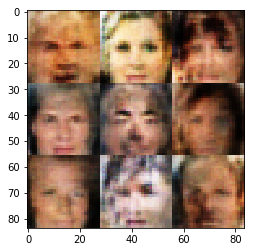

Epoch 1911/1... Discriminator Loss: 0.4467... Generator Loss: 1.2712
Epoch 1921/1... Discriminator Loss: 0.5150... Generator Loss: 1.4685
Epoch 1931/1... Discriminator Loss: 0.4622... Generator Loss: 1.3714
Epoch 1941/1... Discriminator Loss: 0.6397... Generator Loss: 1.0306
Epoch 1951/1... Discriminator Loss: 0.5420... Generator Loss: 1.1780
Epoch 1961/1... Discriminator Loss: 0.7309... Generator Loss: 0.9428
Epoch 1971/1... Discriminator Loss: 0.3361... Generator Loss: 1.7913
Epoch 1981/1... Discriminator Loss: 0.3263... Generator Loss: 1.8606
Epoch 1991/1... Discriminator Loss: 0.9735... Generator Loss: 0.7015
Epoch 2001/1... Discriminator Loss: 0.4197... Generator Loss: 2.3978


Epoch 2011/1... Discriminator Loss: 0.5884... Generator Loss: 1.2620
Epoch 2021/1... Discriminator Loss: 0.3889... Generator Loss: 1.5755
Epoch 2031/1... Discriminator Loss: 0.7585... Generator Loss: 0.8614
Epoch 2041/1... Discriminator Loss: 0.3806... Generator Loss: 1.7419
Epoch 2051/1... Discriminator Loss: 0.3163... Generator Loss: 1.9189
Epoch 2061/1... Discriminator Loss: 0.9859... Generator Loss: 0.5733
Epoch 2071/1... Discriminator Loss: 0.2465... Generator Loss: 2.6622
Epoch 2081/1... Discriminator Loss: 0.4259... Generator Loss: 1.7718
Epoch 2091/1... Discriminator Loss: 0.6331... Generator Loss: 1.0872
Epoch 2101/1... Discriminator Loss: 0.4858... Generator Loss: 1.3835


Epoch 2111/1... Discriminator Loss: 0.5149... Generator Loss: 1.4111
Epoch 2121/1... Discriminator Loss: 0.6316... Generator Loss: 1.0074
Epoch 2131/1... Discriminator Loss: 0.4702... Generator Loss: 1.5446
Epoch 2141/1... Discriminator Loss: 0.4931... Generator Loss: 1.2069
Epoch 2151/1... Discriminator Loss: 0.3560... Generator Loss: 1.6613
Epoch 2161/1... Discriminator Loss: 0.5305... Generator Loss: 1.4771
Epoch 2171/1... Discriminator Loss: 0.5265... Generator Loss: 1.3450
Epoch 2181/1... Discriminator Loss: 0.4208... Generator Loss: 1.8539
Epoch 2191/1... Discriminator Loss: 0.3858... Generator Loss: 1.9687
Epoch 2201/1... Discriminator Loss: 0.9505... Generator Loss: 0.6877


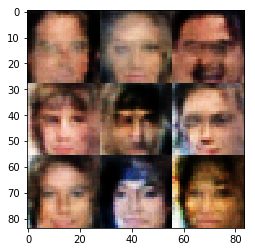

Epoch 2211/1... Discriminator Loss: 1.0693... Generator Loss: 0.6142
Epoch 2221/1... Discriminator Loss: 0.7474... Generator Loss: 0.9776
Epoch 2231/1... Discriminator Loss: 0.5168... Generator Loss: 1.1556
Epoch 2241/1... Discriminator Loss: 0.5774... Generator Loss: 1.4027
Epoch 2251/1... Discriminator Loss: 0.4039... Generator Loss: 2.2651
Epoch 2261/1... Discriminator Loss: 0.6250... Generator Loss: 1.0279
Epoch 2271/1... Discriminator Loss: 0.6894... Generator Loss: 0.9512
Epoch 2281/1... Discriminator Loss: 1.0501... Generator Loss: 0.7178
Epoch 2291/1... Discriminator Loss: 0.3720... Generator Loss: 1.9340
Epoch 2301/1... Discriminator Loss: 0.5623... Generator Loss: 1.5632


Epoch 2311/1... Discriminator Loss: 0.3700... Generator Loss: 1.8009
Epoch 2321/1... Discriminator Loss: 0.6719... Generator Loss: 2.4417
Epoch 2331/1... Discriminator Loss: 1.1883... Generator Loss: 0.4336
Epoch 2341/1... Discriminator Loss: 0.3748... Generator Loss: 2.5052
Epoch 2351/1... Discriminator Loss: 0.4183... Generator Loss: 1.5442
Epoch 2361/1... Discriminator Loss: 0.3879... Generator Loss: 1.8719
Epoch 2371/1... Discriminator Loss: 0.3965... Generator Loss: 1.4764
Epoch 2381/1... Discriminator Loss: 0.9588... Generator Loss: 0.6830
Epoch 2391/1... Discriminator Loss: 0.2938... Generator Loss: 1.7573
Epoch 2401/1... Discriminator Loss: 0.4504... Generator Loss: 2.0893


Epoch 2411/1... Discriminator Loss: 0.3784... Generator Loss: 1.7826
Epoch 2421/1... Discriminator Loss: 0.3423... Generator Loss: 1.6045
Epoch 2431/1... Discriminator Loss: 0.4001... Generator Loss: 1.8215
Epoch 2441/1... Discriminator Loss: 0.6040... Generator Loss: 1.0661
Epoch 2451/1... Discriminator Loss: 0.7461... Generator Loss: 2.9031
Epoch 2461/1... Discriminator Loss: 0.7412... Generator Loss: 0.9250
Epoch 2471/1... Discriminator Loss: 0.9013... Generator Loss: 2.5100
Epoch 2481/1... Discriminator Loss: 0.5596... Generator Loss: 1.2567
Epoch 2491/1... Discriminator Loss: 0.6897... Generator Loss: 0.8835
Epoch 2501/1... Discriminator Loss: 0.4286... Generator Loss: 1.7816


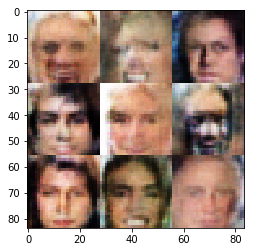

Epoch 2511/1... Discriminator Loss: 0.5261... Generator Loss: 2.2951
Epoch 2521/1... Discriminator Loss: 0.7884... Generator Loss: 0.8378
Epoch 2531/1... Discriminator Loss: 0.3709... Generator Loss: 2.1793
Epoch 2541/1... Discriminator Loss: 0.5860... Generator Loss: 1.2177
Epoch 2551/1... Discriminator Loss: 0.3811... Generator Loss: 1.5974
Epoch 2561/1... Discriminator Loss: 0.5086... Generator Loss: 1.4219
Epoch 2571/1... Discriminator Loss: 0.6772... Generator Loss: 0.9238
Epoch 2581/1... Discriminator Loss: 0.5042... Generator Loss: 1.9540
Epoch 2591/1... Discriminator Loss: 0.3717... Generator Loss: 1.9316
Epoch 2601/1... Discriminator Loss: 0.4408... Generator Loss: 1.4809


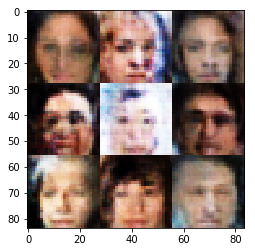

Epoch 2611/1... Discriminator Loss: 0.7784... Generator Loss: 0.8530
Epoch 2621/1... Discriminator Loss: 0.4210... Generator Loss: 1.4350
Epoch 2631/1... Discriminator Loss: 0.3913... Generator Loss: 2.2403
Epoch 2641/1... Discriminator Loss: 0.4974... Generator Loss: 1.4438
Epoch 2651/1... Discriminator Loss: 0.3786... Generator Loss: 1.6073
Epoch 2661/1... Discriminator Loss: 0.4210... Generator Loss: 1.7812
Epoch 2671/1... Discriminator Loss: 0.9678... Generator Loss: 0.5954
Epoch 2681/1... Discriminator Loss: 1.2703... Generator Loss: 0.4106
Epoch 2691/1... Discriminator Loss: 0.2817... Generator Loss: 2.0109
Epoch 2701/1... Discriminator Loss: 0.3903... Generator Loss: 1.6422


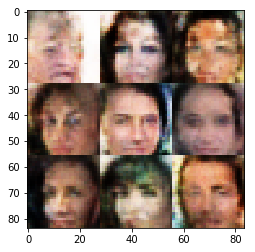

Epoch 2711/1... Discriminator Loss: 0.5193... Generator Loss: 1.1785
Epoch 2721/1... Discriminator Loss: 0.5351... Generator Loss: 1.0727
Epoch 2731/1... Discriminator Loss: 0.6092... Generator Loss: 1.1052
Epoch 2741/1... Discriminator Loss: 0.5171... Generator Loss: 1.2010
Epoch 2751/1... Discriminator Loss: 0.9834... Generator Loss: 0.5246
Epoch 2761/1... Discriminator Loss: 0.3989... Generator Loss: 1.7498
Epoch 2771/1... Discriminator Loss: 0.3508... Generator Loss: 1.8827
Epoch 2781/1... Discriminator Loss: 0.5018... Generator Loss: 1.7982
Epoch 2791/1... Discriminator Loss: 1.0013... Generator Loss: 0.6193
Epoch 2801/1... Discriminator Loss: 0.8606... Generator Loss: 0.7428


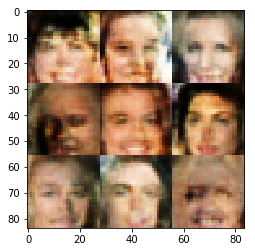

Epoch 2811/1... Discriminator Loss: 0.5568... Generator Loss: 1.0719
Epoch 2821/1... Discriminator Loss: 0.7809... Generator Loss: 0.8162
Epoch 2831/1... Discriminator Loss: 0.3628... Generator Loss: 1.8822
Epoch 2841/1... Discriminator Loss: 0.5010... Generator Loss: 1.5771
Epoch 2851/1... Discriminator Loss: 1.3319... Generator Loss: 0.3994
Epoch 2861/1... Discriminator Loss: 0.4346... Generator Loss: 1.3989
Epoch 2871/1... Discriminator Loss: 0.2676... Generator Loss: 2.3592
Epoch 2881/1... Discriminator Loss: 0.7227... Generator Loss: 0.9699
Epoch 2891/1... Discriminator Loss: 0.5460... Generator Loss: 1.5090
Epoch 2901/1... Discriminator Loss: 0.9562... Generator Loss: 0.6770


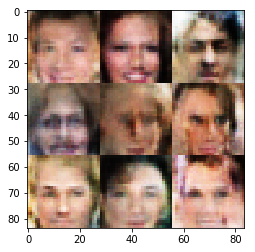

Epoch 2911/1... Discriminator Loss: 0.4558... Generator Loss: 2.5036
Epoch 2921/1... Discriminator Loss: 0.8444... Generator Loss: 0.6831
Epoch 2931/1... Discriminator Loss: 0.5236... Generator Loss: 2.2149
Epoch 2941/1... Discriminator Loss: 0.9423... Generator Loss: 0.5788
Epoch 2951/1... Discriminator Loss: 0.3366... Generator Loss: 2.1293
Epoch 2961/1... Discriminator Loss: 0.4040... Generator Loss: 2.3164
Epoch 2971/1... Discriminator Loss: 0.7631... Generator Loss: 0.8901
Epoch 2981/1... Discriminator Loss: 1.4811... Generator Loss: 0.3462
Epoch 2991/1... Discriminator Loss: 0.8684... Generator Loss: 0.7211
Epoch 3001/1... Discriminator Loss: 0.3083... Generator Loss: 2.1124


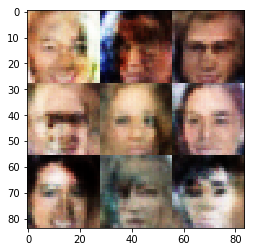

Epoch 3011/1... Discriminator Loss: 0.2916... Generator Loss: 1.9734
Epoch 3021/1... Discriminator Loss: 0.6354... Generator Loss: 2.0399
Epoch 3031/1... Discriminator Loss: 0.6794... Generator Loss: 0.8692
Epoch 3041/1... Discriminator Loss: 0.5459... Generator Loss: 2.0920
Epoch 3051/1... Discriminator Loss: 0.4236... Generator Loss: 1.9805
Epoch 3061/1... Discriminator Loss: 0.6141... Generator Loss: 1.3107
Epoch 3071/1... Discriminator Loss: 0.5702... Generator Loss: 2.0303
Epoch 3081/1... Discriminator Loss: 0.4040... Generator Loss: 1.6222
Epoch 3091/1... Discriminator Loss: 1.1299... Generator Loss: 0.6218
Epoch 3101/1... Discriminator Loss: 0.4049... Generator Loss: 1.8468


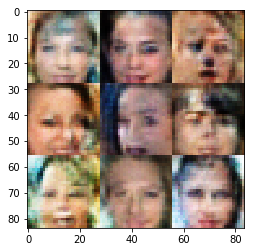

Epoch 3111/1... Discriminator Loss: 0.5804... Generator Loss: 1.2254
Epoch 3121/1... Discriminator Loss: 0.5715... Generator Loss: 2.6041
Epoch 3131/1... Discriminator Loss: 0.4393... Generator Loss: 1.9059
Epoch 3141/1... Discriminator Loss: 0.3983... Generator Loss: 1.4580
Epoch 3151/1... Discriminator Loss: 0.6507... Generator Loss: 0.9938
Epoch 3161/1... Discriminator Loss: 0.5225... Generator Loss: 1.0589
Epoch 3171/1... Discriminator Loss: 0.3509... Generator Loss: 3.3020
Epoch 3181/1... Discriminator Loss: 0.6953... Generator Loss: 1.0117
Epoch 3191/1... Discriminator Loss: 0.2848... Generator Loss: 1.8078
Epoch 3201/1... Discriminator Loss: 0.3502... Generator Loss: 1.6425


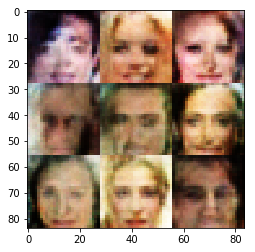

Epoch 3211/1... Discriminator Loss: 1.2788... Generator Loss: 0.5313
Epoch 3221/1... Discriminator Loss: 0.4243... Generator Loss: 1.4164
Epoch 3231/1... Discriminator Loss: 0.3665... Generator Loss: 1.5591
Epoch 3241/1... Discriminator Loss: 0.3916... Generator Loss: 2.2314
Epoch 3251/1... Discriminator Loss: 0.4046... Generator Loss: 1.3925
Epoch 3261/1... Discriminator Loss: 0.4380... Generator Loss: 1.3924
Epoch 3271/1... Discriminator Loss: 0.2906... Generator Loss: 2.1574
Epoch 3281/1... Discriminator Loss: 0.4630... Generator Loss: 1.6015
Epoch 3291/1... Discriminator Loss: 0.5939... Generator Loss: 1.2205
Epoch 3301/1... Discriminator Loss: 0.6300... Generator Loss: 1.1171


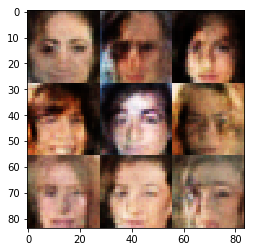

Epoch 3311/1... Discriminator Loss: 0.6368... Generator Loss: 1.0280
Epoch 3321/1... Discriminator Loss: 0.7724... Generator Loss: 0.7558
Epoch 3331/1... Discriminator Loss: 0.7070... Generator Loss: 0.9538
Epoch 3341/1... Discriminator Loss: 0.7161... Generator Loss: 2.4429
Epoch 3351/1... Discriminator Loss: 0.4612... Generator Loss: 1.4230
Epoch 3361/1... Discriminator Loss: 0.3974... Generator Loss: 1.8743
Epoch 3371/1... Discriminator Loss: 0.5343... Generator Loss: 3.1177
Epoch 3381/1... Discriminator Loss: 0.3363... Generator Loss: 1.8455
Epoch 3391/1... Discriminator Loss: 0.5098... Generator Loss: 1.3817
Epoch 3401/1... Discriminator Loss: 0.4510... Generator Loss: 1.6486


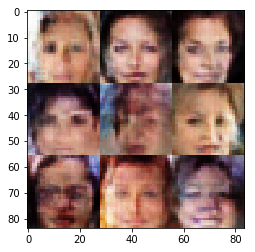

Epoch 3411/1... Discriminator Loss: 0.4477... Generator Loss: 1.2659
Epoch 3421/1... Discriminator Loss: 0.4358... Generator Loss: 1.3826
Epoch 3431/1... Discriminator Loss: 0.6799... Generator Loss: 0.9667
Epoch 3441/1... Discriminator Loss: 0.5836... Generator Loss: 1.3286
Epoch 3451/1... Discriminator Loss: 0.5784... Generator Loss: 1.6024
Epoch 3461/1... Discriminator Loss: 0.5449... Generator Loss: 1.1184
Epoch 3471/1... Discriminator Loss: 0.5740... Generator Loss: 2.8942
Epoch 3481/1... Discriminator Loss: 0.3227... Generator Loss: 1.9218
Epoch 3491/1... Discriminator Loss: 0.2743... Generator Loss: 2.3141
Epoch 3501/1... Discriminator Loss: 0.5295... Generator Loss: 1.3511


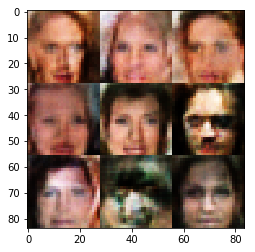

Epoch 3511/1... Discriminator Loss: 0.2824... Generator Loss: 1.8973
Epoch 3521/1... Discriminator Loss: 0.7235... Generator Loss: 0.8276
Epoch 3531/1... Discriminator Loss: 0.4739... Generator Loss: 1.5590
Epoch 3541/1... Discriminator Loss: 0.6036... Generator Loss: 1.1616
Epoch 3551/1... Discriminator Loss: 0.6454... Generator Loss: 1.0831
Epoch 3561/1... Discriminator Loss: 0.4616... Generator Loss: 1.5447
Epoch 3571/1... Discriminator Loss: 0.5921... Generator Loss: 1.1586
Epoch 3581/1... Discriminator Loss: 0.4125... Generator Loss: 1.5605
Epoch 3591/1... Discriminator Loss: 0.3369... Generator Loss: 2.3065
Epoch 3601/1... Discriminator Loss: 0.3294... Generator Loss: 2.5400


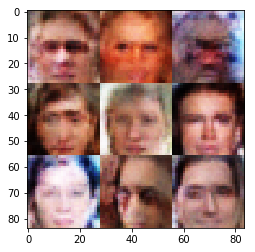

Epoch 3611/1... Discriminator Loss: 0.6312... Generator Loss: 0.9878
Epoch 3621/1... Discriminator Loss: 0.3296... Generator Loss: 1.7879
Epoch 3631/1... Discriminator Loss: 0.5326... Generator Loss: 1.3070
Epoch 3641/1... Discriminator Loss: 0.4476... Generator Loss: 1.4122
Epoch 3651/1... Discriminator Loss: 0.5309... Generator Loss: 1.1763
Epoch 3661/1... Discriminator Loss: 0.6729... Generator Loss: 0.8962
Epoch 3671/1... Discriminator Loss: 0.5414... Generator Loss: 1.1984
Epoch 3681/1... Discriminator Loss: 0.7904... Generator Loss: 0.7410
Epoch 3691/1... Discriminator Loss: 0.3677... Generator Loss: 1.8130
Epoch 3701/1... Discriminator Loss: 0.3954... Generator Loss: 1.7940


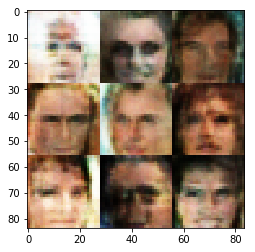

Epoch 3711/1... Discriminator Loss: 0.2651... Generator Loss: 2.1520
Epoch 3721/1... Discriminator Loss: 0.3484... Generator Loss: 1.6970
Epoch 3731/1... Discriminator Loss: 0.5990... Generator Loss: 1.7361
Epoch 3741/1... Discriminator Loss: 0.4776... Generator Loss: 2.1323
Epoch 3751/1... Discriminator Loss: 0.4469... Generator Loss: 1.6572
Epoch 3761/1... Discriminator Loss: 0.7592... Generator Loss: 0.9572
Epoch 3771/1... Discriminator Loss: 0.3533... Generator Loss: 1.9238
Epoch 3781/1... Discriminator Loss: 1.0777... Generator Loss: 0.5232
Epoch 3791/1... Discriminator Loss: 0.7285... Generator Loss: 0.9914
Epoch 3801/1... Discriminator Loss: 0.6364... Generator Loss: 0.9583


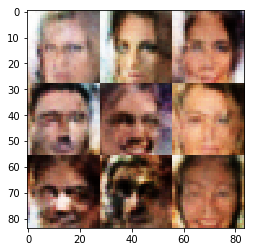

Epoch 3811/1... Discriminator Loss: 0.3413... Generator Loss: 1.8273
Epoch 3821/1... Discriminator Loss: 0.4979... Generator Loss: 1.2331
Epoch 3831/1... Discriminator Loss: 0.5401... Generator Loss: 1.2790
Epoch 3841/1... Discriminator Loss: 1.1220... Generator Loss: 0.4981
Epoch 3851/1... Discriminator Loss: 1.2348... Generator Loss: 0.4638
Epoch 3861/1... Discriminator Loss: 0.3556... Generator Loss: 1.7645
Epoch 3871/1... Discriminator Loss: 0.2701... Generator Loss: 1.8877
Epoch 3881/1... Discriminator Loss: 1.0421... Generator Loss: 0.6742
Epoch 3891/1... Discriminator Loss: 0.4488... Generator Loss: 1.4723
Epoch 3901/1... Discriminator Loss: 0.6613... Generator Loss: 1.2187


Epoch 3911/1... Discriminator Loss: 0.5508... Generator Loss: 1.1943
Epoch 3921/1... Discriminator Loss: 1.1141... Generator Loss: 0.5175
Epoch 3931/1... Discriminator Loss: 0.4609... Generator Loss: 1.8193
Epoch 3941/1... Discriminator Loss: 0.5295... Generator Loss: 1.3041
Epoch 3951/1... Discriminator Loss: 0.5672... Generator Loss: 1.3325
Epoch 3961/1... Discriminator Loss: 0.2311... Generator Loss: 2.5948
Epoch 3971/1... Discriminator Loss: 0.6671... Generator Loss: 0.9564
Epoch 3981/1... Discriminator Loss: 0.4588... Generator Loss: 2.3633
Epoch 3991/1... Discriminator Loss: 1.0347... Generator Loss: 0.5986
Epoch 4001/1... Discriminator Loss: 0.5805... Generator Loss: 1.6675


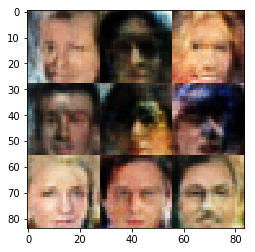

Epoch 4011/1... Discriminator Loss: 0.5685... Generator Loss: 1.2894
Epoch 4021/1... Discriminator Loss: 0.5475... Generator Loss: 1.3639
Epoch 4031/1... Discriminator Loss: 0.4498... Generator Loss: 1.8774
Epoch 4041/1... Discriminator Loss: 0.4854... Generator Loss: 1.4977
Epoch 4051/1... Discriminator Loss: 0.4040... Generator Loss: 1.8077
Epoch 4061/1... Discriminator Loss: 0.5592... Generator Loss: 2.0923
Epoch 4071/1... Discriminator Loss: 0.8552... Generator Loss: 0.6850
Epoch 4081/1... Discriminator Loss: 0.4674... Generator Loss: 1.2234
Epoch 4091/1... Discriminator Loss: 0.3311... Generator Loss: 2.7963
Epoch 4101/1... Discriminator Loss: 0.5170... Generator Loss: 1.3260


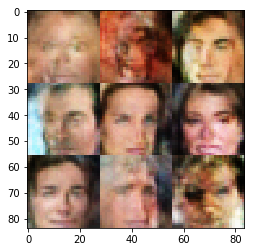

Epoch 4111/1... Discriminator Loss: 0.5581... Generator Loss: 1.0633
Epoch 4121/1... Discriminator Loss: 0.4227... Generator Loss: 1.3950
Epoch 4131/1... Discriminator Loss: 0.9899... Generator Loss: 0.6783
Epoch 4141/1... Discriminator Loss: 0.7841... Generator Loss: 0.9577
Epoch 4151/1... Discriminator Loss: 0.5440... Generator Loss: 1.1052
Epoch 4161/1... Discriminator Loss: 1.0448... Generator Loss: 0.5304
Epoch 4171/1... Discriminator Loss: 0.6664... Generator Loss: 0.9216
Epoch 4181/1... Discriminator Loss: 0.4909... Generator Loss: 2.9297
Epoch 4191/1... Discriminator Loss: 0.4956... Generator Loss: 1.3533
Epoch 4201/1... Discriminator Loss: 0.4264... Generator Loss: 1.5310


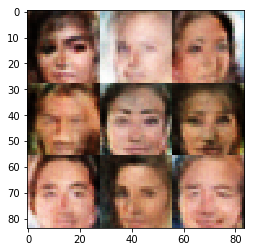

Epoch 4211/1... Discriminator Loss: 0.5938... Generator Loss: 1.2314
Epoch 4221/1... Discriminator Loss: 0.4089... Generator Loss: 1.3964
Epoch 4231/1... Discriminator Loss: 0.4373... Generator Loss: 1.6290
Epoch 4241/1... Discriminator Loss: 0.8208... Generator Loss: 0.7870
Epoch 4251/1... Discriminator Loss: 0.6544... Generator Loss: 1.5441
Epoch 4261/1... Discriminator Loss: 0.3616... Generator Loss: 1.4270
Epoch 4271/1... Discriminator Loss: 0.8335... Generator Loss: 0.7591
Epoch 4281/1... Discriminator Loss: 1.0674... Generator Loss: 0.5904
Epoch 4291/1... Discriminator Loss: 0.7415... Generator Loss: 0.8518
Epoch 4301/1... Discriminator Loss: 0.7314... Generator Loss: 0.8544


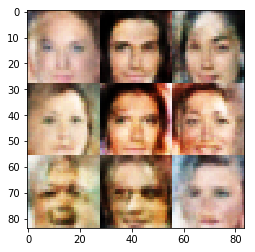

Epoch 4311/1... Discriminator Loss: 0.5916... Generator Loss: 1.3250
Epoch 4321/1... Discriminator Loss: 0.6296... Generator Loss: 1.1055
Epoch 4331/1... Discriminator Loss: 0.7687... Generator Loss: 2.6119
Epoch 4341/1... Discriminator Loss: 0.7408... Generator Loss: 0.8514
Epoch 4351/1... Discriminator Loss: 0.5885... Generator Loss: 0.9736
Epoch 4361/1... Discriminator Loss: 0.5540... Generator Loss: 1.1467
Epoch 4371/1... Discriminator Loss: 0.5424... Generator Loss: 1.3748
Epoch 4381/1... Discriminator Loss: 0.6357... Generator Loss: 1.0658
Epoch 4391/1... Discriminator Loss: 0.6919... Generator Loss: 1.5727
Epoch 4401/1... Discriminator Loss: 0.4588... Generator Loss: 1.6604


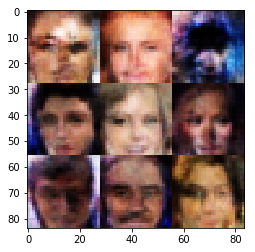

Epoch 4411/1... Discriminator Loss: 0.3602... Generator Loss: 2.2636
Epoch 4421/1... Discriminator Loss: 0.4204... Generator Loss: 1.5187
Epoch 4431/1... Discriminator Loss: 0.4863... Generator Loss: 1.4799
Epoch 4441/1... Discriminator Loss: 1.0654... Generator Loss: 0.6172
Epoch 4451/1... Discriminator Loss: 0.5799... Generator Loss: 1.1003
Epoch 4461/1... Discriminator Loss: 0.5738... Generator Loss: 0.9706
Epoch 4471/1... Discriminator Loss: 0.5248... Generator Loss: 1.4753
Epoch 4481/1... Discriminator Loss: 0.6370... Generator Loss: 0.8838
Epoch 4491/1... Discriminator Loss: 0.3727... Generator Loss: 1.8439
Epoch 4501/1... Discriminator Loss: 1.0125... Generator Loss: 0.5771


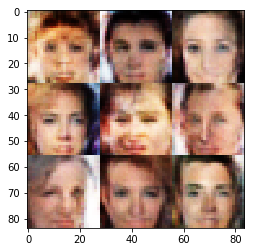

Epoch 4511/1... Discriminator Loss: 1.0889... Generator Loss: 0.5338
Epoch 4521/1... Discriminator Loss: 0.6121... Generator Loss: 1.0873
Epoch 4531/1... Discriminator Loss: 0.4543... Generator Loss: 2.3286
Epoch 4541/1... Discriminator Loss: 0.4397... Generator Loss: 1.6361
Epoch 4551/1... Discriminator Loss: 0.3865... Generator Loss: 2.2031
Epoch 4561/1... Discriminator Loss: 0.9042... Generator Loss: 0.6554
Epoch 4571/1... Discriminator Loss: 0.3918... Generator Loss: 1.6484
Epoch 4581/1... Discriminator Loss: 0.4812... Generator Loss: 1.6047
Epoch 4591/1... Discriminator Loss: 0.3977... Generator Loss: 2.5055
Epoch 4601/1... Discriminator Loss: 0.6821... Generator Loss: 0.9035


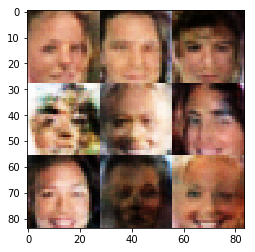

Epoch 4611/1... Discriminator Loss: 0.6259... Generator Loss: 1.2281
Epoch 4621/1... Discriminator Loss: 0.3774... Generator Loss: 2.1283
Epoch 4631/1... Discriminator Loss: 0.5140... Generator Loss: 1.2292
Epoch 4641/1... Discriminator Loss: 0.6306... Generator Loss: 1.0763
Epoch 4651/1... Discriminator Loss: 0.6752... Generator Loss: 1.1097
Epoch 4661/1... Discriminator Loss: 0.4066... Generator Loss: 1.4740
Epoch 4671/1... Discriminator Loss: 0.5159... Generator Loss: 1.4766
Epoch 4681/1... Discriminator Loss: 0.6539... Generator Loss: 1.1880
Epoch 4691/1... Discriminator Loss: 0.3337... Generator Loss: 1.7539
Epoch 4701/1... Discriminator Loss: 0.4547... Generator Loss: 1.3431


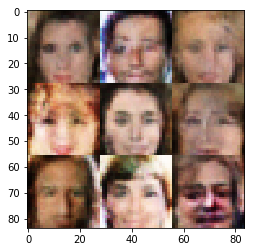

Epoch 4711/1... Discriminator Loss: 0.6461... Generator Loss: 0.9484
Epoch 4721/1... Discriminator Loss: 0.3921... Generator Loss: 2.4200
Epoch 4731/1... Discriminator Loss: 0.3770... Generator Loss: 1.7544
Epoch 4741/1... Discriminator Loss: 0.7775... Generator Loss: 0.9322
Epoch 4751/1... Discriminator Loss: 0.3015... Generator Loss: 1.8667
Epoch 4761/1... Discriminator Loss: 0.4586... Generator Loss: 1.5528
Epoch 4771/1... Discriminator Loss: 0.5718... Generator Loss: 1.0775
Epoch 4781/1... Discriminator Loss: 0.7140... Generator Loss: 1.2209
Epoch 4791/1... Discriminator Loss: 0.4705... Generator Loss: 2.4667
Epoch 4801/1... Discriminator Loss: 0.3773... Generator Loss: 1.6813


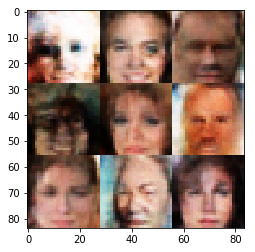

Epoch 4811/1... Discriminator Loss: 0.4308... Generator Loss: 1.2471
Epoch 4821/1... Discriminator Loss: 0.9531... Generator Loss: 0.5786
Epoch 4831/1... Discriminator Loss: 0.7567... Generator Loss: 1.0064
Epoch 4841/1... Discriminator Loss: 0.3921... Generator Loss: 1.4072
Epoch 4851/1... Discriminator Loss: 0.8283... Generator Loss: 0.7058
Epoch 4861/1... Discriminator Loss: 0.5446... Generator Loss: 1.1906
Epoch 4871/1... Discriminator Loss: 0.6009... Generator Loss: 1.0343
Epoch 4881/1... Discriminator Loss: 0.6373... Generator Loss: 1.1089
Epoch 4891/1... Discriminator Loss: 0.3381... Generator Loss: 2.1770
Epoch 4901/1... Discriminator Loss: 0.7536... Generator Loss: 0.9778


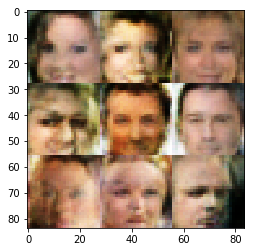

Epoch 4911/1... Discriminator Loss: 1.0298... Generator Loss: 0.6289
Epoch 4921/1... Discriminator Loss: 0.6024... Generator Loss: 1.4231
Epoch 4931/1... Discriminator Loss: 0.2546... Generator Loss: 2.2892
Epoch 4941/1... Discriminator Loss: 0.3110... Generator Loss: 1.8677
Epoch 4951/1... Discriminator Loss: 0.7420... Generator Loss: 0.8466
Epoch 4961/1... Discriminator Loss: 0.5733... Generator Loss: 1.2725
Epoch 4971/1... Discriminator Loss: 0.9829... Generator Loss: 0.7983
Epoch 4981/1... Discriminator Loss: 0.7061... Generator Loss: 0.9391
Epoch 4991/1... Discriminator Loss: 0.7504... Generator Loss: 1.0170
Epoch 5001/1... Discriminator Loss: 0.5915... Generator Loss: 1.5821


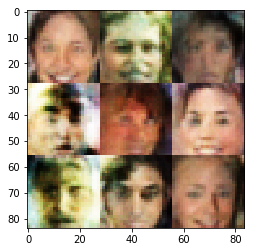

Epoch 5011/1... Discriminator Loss: 0.4847... Generator Loss: 1.5868
Epoch 5021/1... Discriminator Loss: 0.3193... Generator Loss: 2.1858
Epoch 5031/1... Discriminator Loss: 0.2823... Generator Loss: 2.1740
Epoch 5041/1... Discriminator Loss: 0.4927... Generator Loss: 1.5417
Epoch 5051/1... Discriminator Loss: 0.6603... Generator Loss: 1.1428
Epoch 5061/1... Discriminator Loss: 1.2614... Generator Loss: 0.4605
Epoch 5071/1... Discriminator Loss: 1.3387... Generator Loss: 0.4242
Epoch 5081/1... Discriminator Loss: 0.4971... Generator Loss: 1.4113
Epoch 5091/1... Discriminator Loss: 1.5334... Generator Loss: 0.2960
Epoch 5101/1... Discriminator Loss: 0.4894... Generator Loss: 2.4018


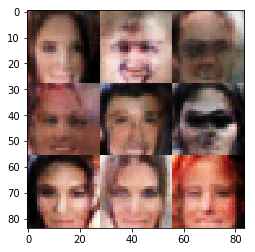

Epoch 5111/1... Discriminator Loss: 0.6523... Generator Loss: 1.0355
Epoch 5121/1... Discriminator Loss: 0.5426... Generator Loss: 1.3787
Epoch 5131/1... Discriminator Loss: 0.3919... Generator Loss: 1.4714
Epoch 5141/1... Discriminator Loss: 1.1382... Generator Loss: 0.4572
Epoch 5151/1... Discriminator Loss: 0.5801... Generator Loss: 1.0838
Epoch 5161/1... Discriminator Loss: 0.3129... Generator Loss: 1.6522
Epoch 5171/1... Discriminator Loss: 0.5396... Generator Loss: 1.2348
Epoch 5181/1... Discriminator Loss: 0.4138... Generator Loss: 1.6717
Epoch 5191/1... Discriminator Loss: 0.3863... Generator Loss: 2.3438
Epoch 5201/1... Discriminator Loss: 1.1749... Generator Loss: 0.4714


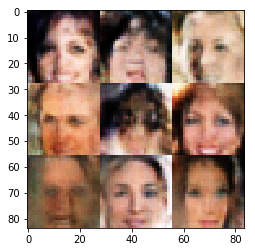

Epoch 5211/1... Discriminator Loss: 0.4236... Generator Loss: 1.8615
Epoch 5221/1... Discriminator Loss: 0.7136... Generator Loss: 1.0296
Epoch 5231/1... Discriminator Loss: 0.7157... Generator Loss: 0.9638
Epoch 5241/1... Discriminator Loss: 0.3049... Generator Loss: 1.7606
Epoch 5251/1... Discriminator Loss: 0.6135... Generator Loss: 1.1514
Epoch 5261/1... Discriminator Loss: 0.2312... Generator Loss: 2.4532
Epoch 5271/1... Discriminator Loss: 0.8326... Generator Loss: 0.8278
Epoch 5281/1... Discriminator Loss: 0.4808... Generator Loss: 2.0569
Epoch 5291/1... Discriminator Loss: 0.3847... Generator Loss: 2.3200
Epoch 5301/1... Discriminator Loss: 0.6896... Generator Loss: 1.2993


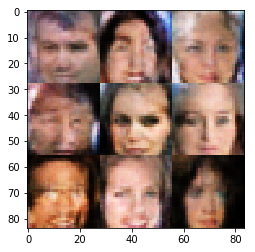

Epoch 5311/1... Discriminator Loss: 0.3770... Generator Loss: 1.5485
Epoch 5321/1... Discriminator Loss: 0.4098... Generator Loss: 1.5751
Epoch 5331/1... Discriminator Loss: 0.3726... Generator Loss: 1.9233
Epoch 5341/1... Discriminator Loss: 0.5652... Generator Loss: 1.5798
Epoch 5351/1... Discriminator Loss: 0.1370... Generator Loss: 2.7329
Epoch 5361/1... Discriminator Loss: 1.3781... Generator Loss: 0.3877
Epoch 5371/1... Discriminator Loss: 0.4163... Generator Loss: 1.7304
Epoch 5381/1... Discriminator Loss: 0.8613... Generator Loss: 0.7216
Epoch 5391/1... Discriminator Loss: 0.4598... Generator Loss: 1.3870
Epoch 5401/1... Discriminator Loss: 0.5818... Generator Loss: 1.4829


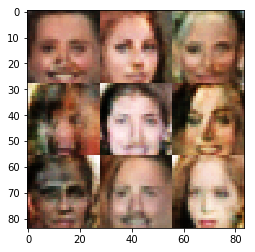

Epoch 5411/1... Discriminator Loss: 0.3898... Generator Loss: 1.6529
Epoch 5421/1... Discriminator Loss: 0.4377... Generator Loss: 1.5676
Epoch 5431/1... Discriminator Loss: 0.2965... Generator Loss: 1.8095
Epoch 5441/1... Discriminator Loss: 0.3972... Generator Loss: 1.7760
Epoch 5451/1... Discriminator Loss: 1.1620... Generator Loss: 0.5141
Epoch 5461/1... Discriminator Loss: 0.5106... Generator Loss: 1.8591
Epoch 5471/1... Discriminator Loss: 0.7142... Generator Loss: 1.1938
Epoch 5481/1... Discriminator Loss: 0.5551... Generator Loss: 1.3008
Epoch 5491/1... Discriminator Loss: 0.6914... Generator Loss: 1.0396
Epoch 5501/1... Discriminator Loss: 0.4838... Generator Loss: 1.3004


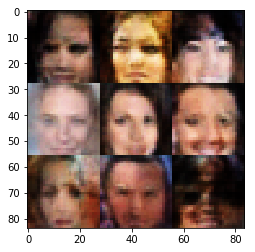

Epoch 5511/1... Discriminator Loss: 0.4757... Generator Loss: 1.4119
Epoch 5521/1... Discriminator Loss: 0.4687... Generator Loss: 1.4449
Epoch 5531/1... Discriminator Loss: 0.6658... Generator Loss: 0.8846
Epoch 5541/1... Discriminator Loss: 0.5880... Generator Loss: 1.3365
Epoch 5551/1... Discriminator Loss: 0.7693... Generator Loss: 0.8771
Epoch 5561/1... Discriminator Loss: 0.5183... Generator Loss: 1.1127
Epoch 5571/1... Discriminator Loss: 0.4517... Generator Loss: 1.7894
Epoch 5581/1... Discriminator Loss: 0.6571... Generator Loss: 0.9920
Epoch 5591/1... Discriminator Loss: 0.7394... Generator Loss: 0.7778
Epoch 5601/1... Discriminator Loss: 0.4954... Generator Loss: 1.5477


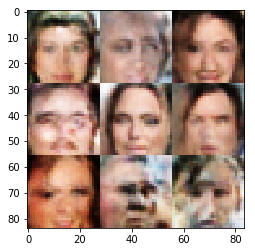

Epoch 5611/1... Discriminator Loss: 0.6623... Generator Loss: 1.3444
Epoch 5621/1... Discriminator Loss: 0.3169... Generator Loss: 1.7330
Epoch 5631/1... Discriminator Loss: 0.3925... Generator Loss: 1.4301
Epoch 5641/1... Discriminator Loss: 0.4683... Generator Loss: 1.6748
Epoch 5651/1... Discriminator Loss: 0.7816... Generator Loss: 0.8454
Epoch 5661/1... Discriminator Loss: 0.2909... Generator Loss: 2.0084
Epoch 5671/1... Discriminator Loss: 0.4026... Generator Loss: 1.9052
Epoch 5681/1... Discriminator Loss: 0.8988... Generator Loss: 0.7474
Epoch 5691/1... Discriminator Loss: 0.5282... Generator Loss: 1.2922
Epoch 5701/1... Discriminator Loss: 1.3246... Generator Loss: 0.3840


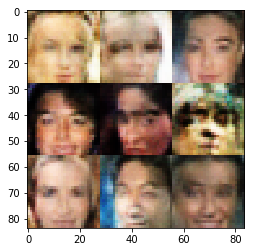

Epoch 5711/1... Discriminator Loss: 0.5443... Generator Loss: 1.2981
Epoch 5721/1... Discriminator Loss: 0.4354... Generator Loss: 1.4141
Epoch 5731/1... Discriminator Loss: 0.5578... Generator Loss: 1.5399
Epoch 5741/1... Discriminator Loss: 0.5893... Generator Loss: 1.7645
Epoch 5751/1... Discriminator Loss: 0.7943... Generator Loss: 0.8531
Epoch 5761/1... Discriminator Loss: 0.3485... Generator Loss: 1.7857
Epoch 5771/1... Discriminator Loss: 0.2489... Generator Loss: 2.0454
Epoch 5781/1... Discriminator Loss: 0.6000... Generator Loss: 1.5036
Epoch 5791/1... Discriminator Loss: 0.5083... Generator Loss: 1.4757
Epoch 5801/1... Discriminator Loss: 0.3375... Generator Loss: 2.0338


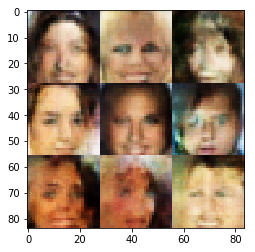

Epoch 5811/1... Discriminator Loss: 0.8054... Generator Loss: 0.8469
Epoch 5821/1... Discriminator Loss: 0.4538... Generator Loss: 1.5058
Epoch 5831/1... Discriminator Loss: 0.1684... Generator Loss: 3.1989
Epoch 5841/1... Discriminator Loss: 0.5797... Generator Loss: 1.3250
Epoch 5851/1... Discriminator Loss: 0.4416... Generator Loss: 2.8584
Epoch 5861/1... Discriminator Loss: 0.7770... Generator Loss: 0.8706
Epoch 5871/1... Discriminator Loss: 0.5126... Generator Loss: 2.0068
Epoch 5881/1... Discriminator Loss: 1.1382... Generator Loss: 0.5157
Epoch 5891/1... Discriminator Loss: 0.6276... Generator Loss: 1.0656
Epoch 5901/1... Discriminator Loss: 0.3092... Generator Loss: 1.8153


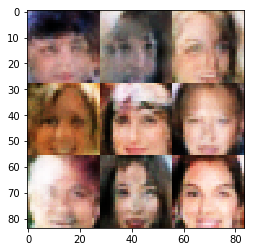

Epoch 5911/1... Discriminator Loss: 0.5860... Generator Loss: 1.1263
Epoch 5921/1... Discriminator Loss: 0.3740... Generator Loss: 1.6175
Epoch 5931/1... Discriminator Loss: 0.4644... Generator Loss: 1.3684
Epoch 5941/1... Discriminator Loss: 0.3187... Generator Loss: 1.8559
Epoch 5951/1... Discriminator Loss: 0.7589... Generator Loss: 0.8559
Epoch 5961/1... Discriminator Loss: 0.3016... Generator Loss: 1.8489
Epoch 5971/1... Discriminator Loss: 0.9955... Generator Loss: 0.5793
Epoch 5981/1... Discriminator Loss: 0.7154... Generator Loss: 0.8876
Epoch 5991/1... Discriminator Loss: 0.4026... Generator Loss: 1.8091
Epoch 6001/1... Discriminator Loss: 0.4908... Generator Loss: 1.3157


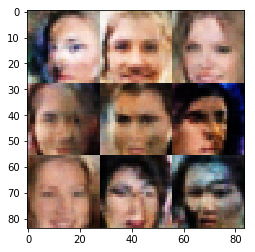

Epoch 6011/1... Discriminator Loss: 0.4632... Generator Loss: 1.4645
Epoch 6021/1... Discriminator Loss: 0.3834... Generator Loss: 1.4731
Epoch 6031/1... Discriminator Loss: 0.7309... Generator Loss: 0.8859
Epoch 6041/1... Discriminator Loss: 0.8196... Generator Loss: 0.7707
Epoch 6051/1... Discriminator Loss: 0.8993... Generator Loss: 0.7643
Epoch 6061/1... Discriminator Loss: 0.3909... Generator Loss: 1.7224
Epoch 6071/1... Discriminator Loss: 0.6623... Generator Loss: 1.0107
Epoch 6081/1... Discriminator Loss: 0.3754... Generator Loss: 1.8365
Epoch 6091/1... Discriminator Loss: 0.4885... Generator Loss: 1.2654
Epoch 6101/1... Discriminator Loss: 0.3206... Generator Loss: 2.2509


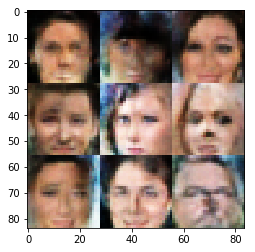

Epoch 6111/1... Discriminator Loss: 0.4144... Generator Loss: 1.4266
Epoch 6121/1... Discriminator Loss: 0.5135... Generator Loss: 1.3284
Epoch 6131/1... Discriminator Loss: 0.4426... Generator Loss: 1.6951
Epoch 6141/1... Discriminator Loss: 1.0238... Generator Loss: 0.6456
Epoch 6151/1... Discriminator Loss: 0.6576... Generator Loss: 0.9757
Epoch 6161/1... Discriminator Loss: 0.1680... Generator Loss: 2.2899
Epoch 6171/1... Discriminator Loss: 0.4772... Generator Loss: 1.1546
Epoch 6181/1... Discriminator Loss: 0.6050... Generator Loss: 0.9797
Epoch 6191/1... Discriminator Loss: 0.5485... Generator Loss: 2.0125
Epoch 6201/1... Discriminator Loss: 1.0018... Generator Loss: 0.6564


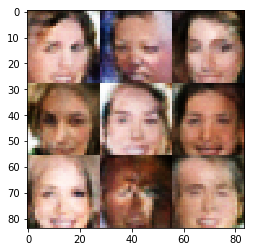

Epoch 6211/1... Discriminator Loss: 0.8344... Generator Loss: 0.8600
Epoch 6221/1... Discriminator Loss: 0.5187... Generator Loss: 1.2305
Epoch 6231/1... Discriminator Loss: 0.3507... Generator Loss: 1.5669
Epoch 6241/1... Discriminator Loss: 0.4035... Generator Loss: 1.5429
Epoch 6251/1... Discriminator Loss: 0.6862... Generator Loss: 1.2881
Epoch 6261/1... Discriminator Loss: 0.4393... Generator Loss: 1.6349
Epoch 6271/1... Discriminator Loss: 0.5533... Generator Loss: 1.6709
Epoch 6281/1... Discriminator Loss: 0.4583... Generator Loss: 1.3967
Epoch 6291/1... Discriminator Loss: 0.4523... Generator Loss: 1.3246
Epoch 6301/1... Discriminator Loss: 0.4437... Generator Loss: 1.4121


Epoch 6311/1... Discriminator Loss: 0.5831... Generator Loss: 1.6240
Epoch 6321/1... Discriminator Loss: 0.4130... Generator Loss: 1.8422
Epoch 6331/1... Discriminator Loss: 0.3056... Generator Loss: 1.7793
Epoch 6341/1... Discriminator Loss: 0.4185... Generator Loss: 1.5578
Epoch 6351/1... Discriminator Loss: 0.3160... Generator Loss: 2.0191
Epoch 6361/1... Discriminator Loss: 0.5931... Generator Loss: 0.9471
Epoch 6371/1... Discriminator Loss: 0.5192... Generator Loss: 1.2090
Epoch 6381/1... Discriminator Loss: 0.6439... Generator Loss: 1.0673
Epoch 6391/1... Discriminator Loss: 0.7656... Generator Loss: 2.4346
Epoch 6401/1... Discriminator Loss: 1.5655... Generator Loss: 0.2955


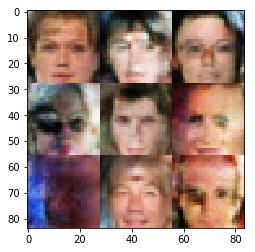

Epoch 6411/1... Discriminator Loss: 0.5035... Generator Loss: 1.7666
Epoch 6421/1... Discriminator Loss: 0.6121... Generator Loss: 1.1136
Epoch 6431/1... Discriminator Loss: 0.5024... Generator Loss: 1.5130
Epoch 6441/1... Discriminator Loss: 0.4292... Generator Loss: 1.5644
Epoch 6451/1... Discriminator Loss: 0.4805... Generator Loss: 1.7132
Epoch 6461/1... Discriminator Loss: 0.7585... Generator Loss: 0.8669
Epoch 6471/1... Discriminator Loss: 0.4845... Generator Loss: 1.3546
Epoch 6481/1... Discriminator Loss: 0.2688... Generator Loss: 2.0992
Epoch 6491/1... Discriminator Loss: 1.0620... Generator Loss: 0.5662
Epoch 6501/1... Discriminator Loss: 0.2929... Generator Loss: 1.8330


Epoch 6511/1... Discriminator Loss: 0.6301... Generator Loss: 1.4979
Epoch 6521/1... Discriminator Loss: 0.5494... Generator Loss: 1.1703
Epoch 6531/1... Discriminator Loss: 0.4869... Generator Loss: 1.2164
Epoch 6541/1... Discriminator Loss: 0.5320... Generator Loss: 2.4243
Epoch 6551/1... Discriminator Loss: 0.5639... Generator Loss: 1.1297
Epoch 6561/1... Discriminator Loss: 0.5798... Generator Loss: 1.1472
Epoch 6571/1... Discriminator Loss: 0.6750... Generator Loss: 0.9801
Epoch 6581/1... Discriminator Loss: 0.5115... Generator Loss: 1.1773
Epoch 6591/1... Discriminator Loss: 0.8095... Generator Loss: 0.8643
Epoch 6601/1... Discriminator Loss: 0.5108... Generator Loss: 1.4872


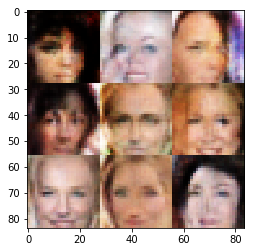

Epoch 6611/1... Discriminator Loss: 0.5699... Generator Loss: 1.2764
Epoch 6621/1... Discriminator Loss: 0.5087... Generator Loss: 1.3892
Epoch 6631/1... Discriminator Loss: 0.5664... Generator Loss: 1.6453
Epoch 6641/1... Discriminator Loss: 0.9944... Generator Loss: 0.5703
Epoch 6651/1... Discriminator Loss: 0.2112... Generator Loss: 3.0486
Epoch 6661/1... Discriminator Loss: 0.5241... Generator Loss: 1.1247
Epoch 6671/1... Discriminator Loss: 0.4821... Generator Loss: 1.3371
Epoch 6681/1... Discriminator Loss: 0.6613... Generator Loss: 1.0415
Epoch 6691/1... Discriminator Loss: 0.4008... Generator Loss: 1.3742
Epoch 6701/1... Discriminator Loss: 0.7142... Generator Loss: 0.8854


Epoch 6711/1... Discriminator Loss: 0.6489... Generator Loss: 1.4059
Epoch 6721/1... Discriminator Loss: 0.7268... Generator Loss: 0.8371
Epoch 6731/1... Discriminator Loss: 0.4199... Generator Loss: 1.6599
Epoch 6741/1... Discriminator Loss: 0.6776... Generator Loss: 2.6030
Epoch 6751/1... Discriminator Loss: 0.1773... Generator Loss: 2.3069
Epoch 6761/1... Discriminator Loss: 0.8005... Generator Loss: 1.1287
Epoch 6771/1... Discriminator Loss: 0.4426... Generator Loss: 1.7760
Epoch 6781/1... Discriminator Loss: 1.0100... Generator Loss: 0.5522
Epoch 6791/1... Discriminator Loss: 0.6574... Generator Loss: 0.9576
Epoch 6801/1... Discriminator Loss: 0.3562... Generator Loss: 1.7520


Epoch 6811/1... Discriminator Loss: 0.6503... Generator Loss: 1.2119
Epoch 6821/1... Discriminator Loss: 0.3751... Generator Loss: 1.5078
Epoch 6831/1... Discriminator Loss: 0.5880... Generator Loss: 1.1640
Epoch 6841/1... Discriminator Loss: 0.2738... Generator Loss: 1.8574
Epoch 6851/1... Discriminator Loss: 0.4148... Generator Loss: 1.5637
Epoch 6861/1... Discriminator Loss: 0.5721... Generator Loss: 1.8055
Epoch 6871/1... Discriminator Loss: 0.3388... Generator Loss: 1.5261
Epoch 6881/1... Discriminator Loss: 0.3075... Generator Loss: 1.9189
Epoch 6891/1... Discriminator Loss: 0.5248... Generator Loss: 1.7218
Epoch 6901/1... Discriminator Loss: 0.6464... Generator Loss: 1.1918


Epoch 6911/1... Discriminator Loss: 0.1169... Generator Loss: 2.5826
Epoch 6921/1... Discriminator Loss: 0.7182... Generator Loss: 0.9500
Epoch 6931/1... Discriminator Loss: 0.7260... Generator Loss: 0.8996
Epoch 6941/1... Discriminator Loss: 0.4088... Generator Loss: 1.6149
Epoch 6951/1... Discriminator Loss: 0.9488... Generator Loss: 0.6521
Epoch 6961/1... Discriminator Loss: 0.2636... Generator Loss: 2.0163
Epoch 6971/1... Discriminator Loss: 0.6478... Generator Loss: 0.9363
Epoch 6981/1... Discriminator Loss: 0.3930... Generator Loss: 1.6091
Epoch 6991/1... Discriminator Loss: 1.0045... Generator Loss: 0.5391
Epoch 7001/1... Discriminator Loss: 0.8363... Generator Loss: 0.9720


Epoch 7011/1... Discriminator Loss: 0.4097... Generator Loss: 1.6869
Epoch 7021/1... Discriminator Loss: 0.4860... Generator Loss: 1.5929
Epoch 7031/1... Discriminator Loss: 0.7682... Generator Loss: 0.7407
Epoch 7041/1... Discriminator Loss: 0.3422... Generator Loss: 1.4914
Epoch 7051/1... Discriminator Loss: 0.5429... Generator Loss: 1.2327
Epoch 7061/1... Discriminator Loss: 0.6304... Generator Loss: 1.1525
Epoch 7071/1... Discriminator Loss: 0.4045... Generator Loss: 1.5924
Epoch 7081/1... Discriminator Loss: 0.5027... Generator Loss: 1.3519
Epoch 7091/1... Discriminator Loss: 0.6231... Generator Loss: 1.3117
Epoch 7101/1... Discriminator Loss: 0.7234... Generator Loss: 0.8575


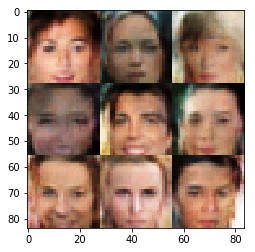

Epoch 7111/1... Discriminator Loss: 0.4646... Generator Loss: 1.6743
Epoch 7121/1... Discriminator Loss: 0.8486... Generator Loss: 0.7685
Epoch 7131/1... Discriminator Loss: 1.1636... Generator Loss: 0.5203
Epoch 7141/1... Discriminator Loss: 0.4318... Generator Loss: 2.3920
Epoch 7151/1... Discriminator Loss: 0.4436... Generator Loss: 1.3617
Epoch 7161/1... Discriminator Loss: 1.0258... Generator Loss: 0.5829
Epoch 7171/1... Discriminator Loss: 0.7055... Generator Loss: 0.9552
Epoch 7181/1... Discriminator Loss: 0.4332... Generator Loss: 2.2263
Epoch 7191/1... Discriminator Loss: 0.7012... Generator Loss: 0.8672
Epoch 7201/1... Discriminator Loss: 0.4583... Generator Loss: 2.8555


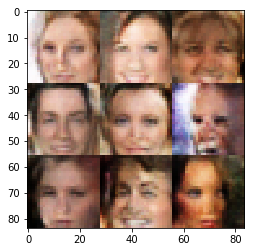

Epoch 7211/1... Discriminator Loss: 0.5960... Generator Loss: 1.0919
Epoch 7221/1... Discriminator Loss: 0.8041... Generator Loss: 0.7712
Epoch 7231/1... Discriminator Loss: 0.8442... Generator Loss: 0.7467
Epoch 7241/1... Discriminator Loss: 0.4498... Generator Loss: 1.5744
Epoch 7251/1... Discriminator Loss: 0.6839... Generator Loss: 0.9228
Epoch 7261/1... Discriminator Loss: 0.5489... Generator Loss: 1.0220
Epoch 7271/1... Discriminator Loss: 0.5096... Generator Loss: 1.3766
Epoch 7281/1... Discriminator Loss: 0.5451... Generator Loss: 1.2390
Epoch 7291/1... Discriminator Loss: 0.7738... Generator Loss: 0.7378
Epoch 7301/1... Discriminator Loss: 0.7280... Generator Loss: 0.8763


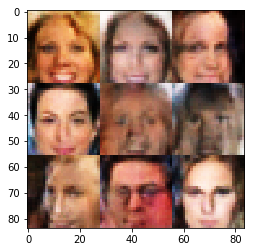

Epoch 7311/1... Discriminator Loss: 0.6405... Generator Loss: 1.1163
Epoch 7321/1... Discriminator Loss: 0.4431... Generator Loss: 1.3470
Epoch 7331/1... Discriminator Loss: 0.7365... Generator Loss: 0.9971
Epoch 7341/1... Discriminator Loss: 0.9182... Generator Loss: 0.8617
Epoch 7351/1... Discriminator Loss: 0.5570... Generator Loss: 1.1110
Epoch 7361/1... Discriminator Loss: 0.3257... Generator Loss: 1.8210
Epoch 7371/1... Discriminator Loss: 0.9691... Generator Loss: 0.7549
Epoch 7381/1... Discriminator Loss: 0.3439... Generator Loss: 1.9453
Epoch 7391/1... Discriminator Loss: 0.5175... Generator Loss: 1.3628
Epoch 7401/1... Discriminator Loss: 0.4064... Generator Loss: 1.6745


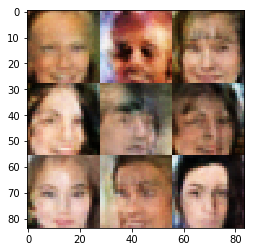

Epoch 7411/1... Discriminator Loss: 0.4107... Generator Loss: 1.6451
Epoch 7421/1... Discriminator Loss: 0.6421... Generator Loss: 1.1340
Epoch 7431/1... Discriminator Loss: 0.4022... Generator Loss: 2.0214
Epoch 7441/1... Discriminator Loss: 0.6280... Generator Loss: 1.0669
Epoch 7451/1... Discriminator Loss: 0.4997... Generator Loss: 1.2114
Epoch 7461/1... Discriminator Loss: 0.3119... Generator Loss: 1.9003
Epoch 7471/1... Discriminator Loss: 0.6407... Generator Loss: 0.9509
Epoch 7481/1... Discriminator Loss: 0.6720... Generator Loss: 0.9119
Epoch 7491/1... Discriminator Loss: 0.2441... Generator Loss: 1.7081
Epoch 7501/1... Discriminator Loss: 1.1407... Generator Loss: 0.5668


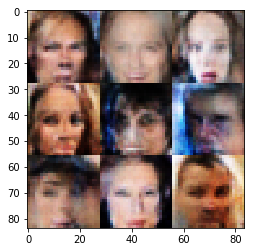

Epoch 7511/1... Discriminator Loss: 1.0604... Generator Loss: 0.6319
Epoch 7521/1... Discriminator Loss: 0.4856... Generator Loss: 1.6511
Epoch 7531/1... Discriminator Loss: 0.5639... Generator Loss: 1.5280
Epoch 7541/1... Discriminator Loss: 0.5314... Generator Loss: 1.3572
Epoch 7551/1... Discriminator Loss: 0.5185... Generator Loss: 1.4043
Epoch 7561/1... Discriminator Loss: 0.4373... Generator Loss: 1.9107
Epoch 7571/1... Discriminator Loss: 0.5278... Generator Loss: 1.2848
Epoch 7581/1... Discriminator Loss: 0.4240... Generator Loss: 1.8968
Epoch 7591/1... Discriminator Loss: 0.5343... Generator Loss: 1.4157
Epoch 7601/1... Discriminator Loss: 0.2047... Generator Loss: 2.8658


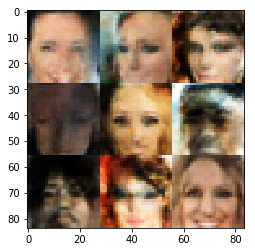

Epoch 7611/1... Discriminator Loss: 0.2599... Generator Loss: 1.9876
Epoch 7621/1... Discriminator Loss: 0.4341... Generator Loss: 2.5893
Epoch 7631/1... Discriminator Loss: 0.6908... Generator Loss: 0.8575
Epoch 7641/1... Discriminator Loss: 0.3183... Generator Loss: 1.7854
Epoch 7651/1... Discriminator Loss: 0.4725... Generator Loss: 1.6178
Epoch 7661/1... Discriminator Loss: 0.7194... Generator Loss: 0.9499
Epoch 7671/1... Discriminator Loss: 1.1900... Generator Loss: 0.4990
Epoch 7681/1... Discriminator Loss: 0.6751... Generator Loss: 1.6108
Epoch 7691/1... Discriminator Loss: 0.6360... Generator Loss: 1.1396
Epoch 7701/1... Discriminator Loss: 0.5314... Generator Loss: 1.7026


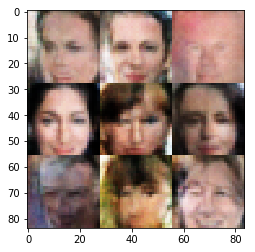

Epoch 7711/1... Discriminator Loss: 0.8719... Generator Loss: 0.6848
Epoch 7721/1... Discriminator Loss: 0.4250... Generator Loss: 1.3333
Epoch 7731/1... Discriminator Loss: 0.1289... Generator Loss: 2.3415
Epoch 7741/1... Discriminator Loss: 0.4400... Generator Loss: 1.3535
Epoch 7751/1... Discriminator Loss: 0.8328... Generator Loss: 0.7924
Epoch 7761/1... Discriminator Loss: 0.5704... Generator Loss: 1.4895
Epoch 7771/1... Discriminator Loss: 0.4491... Generator Loss: 1.8721
Epoch 7781/1... Discriminator Loss: 0.5205... Generator Loss: 1.1601
Epoch 7791/1... Discriminator Loss: 0.5104... Generator Loss: 1.4707
Epoch 7801/1... Discriminator Loss: 0.6709... Generator Loss: 0.9890


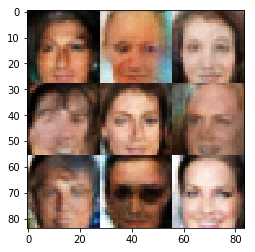

Epoch 7811/1... Discriminator Loss: 0.7402... Generator Loss: 0.8844
Epoch 7821/1... Discriminator Loss: 0.7067... Generator Loss: 0.9613
Epoch 7831/1... Discriminator Loss: 0.5811... Generator Loss: 1.4592
Epoch 7841/1... Discriminator Loss: 0.5483... Generator Loss: 1.3791
Epoch 7851/1... Discriminator Loss: 0.6181... Generator Loss: 1.1606
Epoch 7861/1... Discriminator Loss: 0.4873... Generator Loss: 1.7441
Epoch 7871/1... Discriminator Loss: 1.0099... Generator Loss: 0.6211
Epoch 7881/1... Discriminator Loss: 0.6160... Generator Loss: 1.1843
Epoch 7891/1... Discriminator Loss: 0.3185... Generator Loss: 1.9611
Epoch 7901/1... Discriminator Loss: 0.3449... Generator Loss: 1.9162


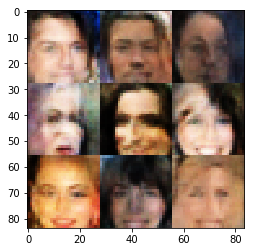

Epoch 7911/1... Discriminator Loss: 0.1877... Generator Loss: 2.4440
Epoch 7921/1... Discriminator Loss: 0.2632... Generator Loss: 2.0364
Epoch 7931/1... Discriminator Loss: 0.6195... Generator Loss: 1.1890
Epoch 7941/1... Discriminator Loss: 0.3229... Generator Loss: 2.0922
Epoch 7951/1... Discriminator Loss: 0.3932... Generator Loss: 1.5447
Epoch 7961/1... Discriminator Loss: 0.6042... Generator Loss: 1.0627
Epoch 7971/1... Discriminator Loss: 0.7237... Generator Loss: 0.9690
Epoch 7981/1... Discriminator Loss: 0.9674... Generator Loss: 0.6101
Epoch 7991/1... Discriminator Loss: 0.9445... Generator Loss: 0.6624
Epoch 8001/1... Discriminator Loss: 0.4270... Generator Loss: 1.4653


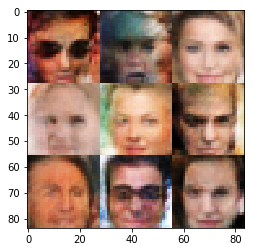

Epoch 8011/1... Discriminator Loss: 0.2996... Generator Loss: 1.8136
Epoch 8021/1... Discriminator Loss: 0.4870... Generator Loss: 1.2718
Epoch 8031/1... Discriminator Loss: 0.4596... Generator Loss: 1.3666
Epoch 8041/1... Discriminator Loss: 0.5267... Generator Loss: 1.1093
Epoch 8051/1... Discriminator Loss: 0.3811... Generator Loss: 1.4870
Epoch 8061/1... Discriminator Loss: 0.5240... Generator Loss: 1.2011
Epoch 8071/1... Discriminator Loss: 0.2755... Generator Loss: 2.9144
Epoch 8081/1... Discriminator Loss: 0.7575... Generator Loss: 1.1034
Epoch 8091/1... Discriminator Loss: 0.5019... Generator Loss: 1.8382
Epoch 8101/1... Discriminator Loss: 1.3060... Generator Loss: 0.4208


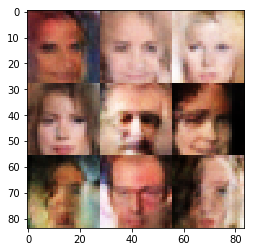

Epoch 8111/1... Discriminator Loss: 0.7094... Generator Loss: 0.9802
Epoch 8121/1... Discriminator Loss: 0.5561... Generator Loss: 1.6960
Epoch 8131/1... Discriminator Loss: 0.4742... Generator Loss: 1.3537
Epoch 8141/1... Discriminator Loss: 0.6756... Generator Loss: 0.9098
Epoch 8151/1... Discriminator Loss: 0.6108... Generator Loss: 1.0515
Epoch 8161/1... Discriminator Loss: 0.3472... Generator Loss: 2.1322
Epoch 8171/1... Discriminator Loss: 1.0063... Generator Loss: 0.5692
Epoch 8181/1... Discriminator Loss: 0.4413... Generator Loss: 1.8635
Epoch 8191/1... Discriminator Loss: 0.2826... Generator Loss: 1.9001
Epoch 8201/1... Discriminator Loss: 1.0734... Generator Loss: 0.4991


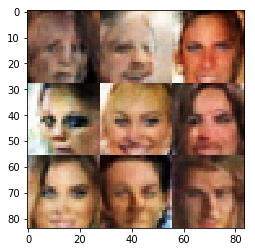

Epoch 8211/1... Discriminator Loss: 0.6984... Generator Loss: 0.8751
Epoch 8221/1... Discriminator Loss: 0.8229... Generator Loss: 0.7408
Epoch 8231/1... Discriminator Loss: 0.8775... Generator Loss: 0.9340
Epoch 8241/1... Discriminator Loss: 1.2053... Generator Loss: 0.4838
Epoch 8251/1... Discriminator Loss: 0.4203... Generator Loss: 1.6586
Epoch 8261/1... Discriminator Loss: 0.5935... Generator Loss: 1.1376
Epoch 8271/1... Discriminator Loss: 1.2548... Generator Loss: 0.4704
Epoch 8281/1... Discriminator Loss: 0.6678... Generator Loss: 1.0057
Epoch 8291/1... Discriminator Loss: 0.3852... Generator Loss: 1.7787
Epoch 8301/1... Discriminator Loss: 0.2848... Generator Loss: 2.3146


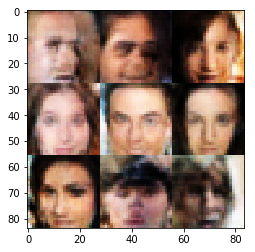

Epoch 8311/1... Discriminator Loss: 0.3307... Generator Loss: 1.6766
Epoch 8321/1... Discriminator Loss: 0.6362... Generator Loss: 1.0741
Epoch 8331/1... Discriminator Loss: 0.4871... Generator Loss: 1.1174
Epoch 8341/1... Discriminator Loss: 1.2735... Generator Loss: 0.4141
Epoch 8351/1... Discriminator Loss: 0.1851... Generator Loss: 2.2844
Epoch 8361/1... Discriminator Loss: 0.5557... Generator Loss: 1.4263
Epoch 8371/1... Discriminator Loss: 0.2946... Generator Loss: 2.4483
Epoch 8381/1... Discriminator Loss: 0.5030... Generator Loss: 1.6772
Epoch 8391/1... Discriminator Loss: 0.3686... Generator Loss: 1.8249
Epoch 8401/1... Discriminator Loss: 0.1547... Generator Loss: 2.6669


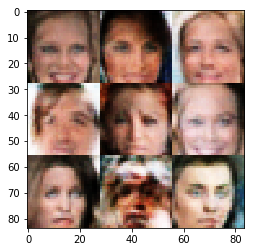

Epoch 8411/1... Discriminator Loss: 0.5128... Generator Loss: 1.5292
Epoch 8421/1... Discriminator Loss: 0.4170... Generator Loss: 1.5205
Epoch 8431/1... Discriminator Loss: 0.9369... Generator Loss: 0.6119
Epoch 8441/1... Discriminator Loss: 0.5636... Generator Loss: 1.6389
Epoch 8451/1... Discriminator Loss: 0.7130... Generator Loss: 1.3797
Epoch 8461/1... Discriminator Loss: 0.4583... Generator Loss: 1.6813
Epoch 8471/1... Discriminator Loss: 0.5219... Generator Loss: 1.6529
Epoch 8481/1... Discriminator Loss: 0.5722... Generator Loss: 1.9131
Epoch 8491/1... Discriminator Loss: 0.6306... Generator Loss: 1.1130
Epoch 8501/1... Discriminator Loss: 0.2944... Generator Loss: 2.1575


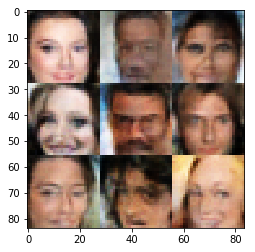

Epoch 8511/1... Discriminator Loss: 0.6151... Generator Loss: 1.1860
Epoch 8521/1... Discriminator Loss: 0.5048... Generator Loss: 1.4210
Epoch 8531/1... Discriminator Loss: 0.6185... Generator Loss: 0.9927
Epoch 8541/1... Discriminator Loss: 0.6472... Generator Loss: 0.9986
Epoch 8551/1... Discriminator Loss: 0.4102... Generator Loss: 1.4535
Epoch 8561/1... Discriminator Loss: 0.5623... Generator Loss: 1.1427
Epoch 8571/1... Discriminator Loss: 0.4460... Generator Loss: 1.4436
Epoch 8581/1... Discriminator Loss: 0.3544... Generator Loss: 1.6569
Epoch 8591/1... Discriminator Loss: 0.6769... Generator Loss: 1.0111
Epoch 8601/1... Discriminator Loss: 0.9029... Generator Loss: 0.6823


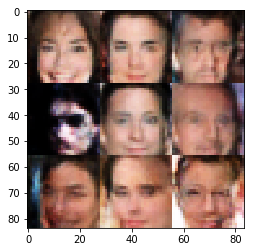

Epoch 8611/1... Discriminator Loss: 0.6114... Generator Loss: 2.4536
Epoch 8621/1... Discriminator Loss: 0.9518... Generator Loss: 0.7370
Epoch 8631/1... Discriminator Loss: 0.3958... Generator Loss: 1.7759
Epoch 8641/1... Discriminator Loss: 0.4354... Generator Loss: 1.4406
Epoch 8651/1... Discriminator Loss: 1.0264... Generator Loss: 0.6299
Epoch 8661/1... Discriminator Loss: 0.3974... Generator Loss: 1.7999
Epoch 8671/1... Discriminator Loss: 1.4247... Generator Loss: 0.3787
Epoch 8681/1... Discriminator Loss: 0.7193... Generator Loss: 0.9408
Epoch 8691/1... Discriminator Loss: 0.4078... Generator Loss: 1.6777
Epoch 8701/1... Discriminator Loss: 0.7307... Generator Loss: 0.9992


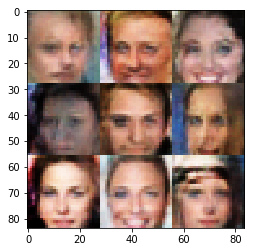

Epoch 8711/1... Discriminator Loss: 0.4353... Generator Loss: 1.4101
Epoch 8721/1... Discriminator Loss: 1.4128... Generator Loss: 0.3423
Epoch 8731/1... Discriminator Loss: 0.3774... Generator Loss: 1.5847
Epoch 8741/1... Discriminator Loss: 0.7445... Generator Loss: 0.9338
Epoch 8751/1... Discriminator Loss: 0.4639... Generator Loss: 1.3454
Epoch 8761/1... Discriminator Loss: 0.4690... Generator Loss: 1.4970
Epoch 8771/1... Discriminator Loss: 0.5505... Generator Loss: 1.1264
Epoch 8781/1... Discriminator Loss: 0.5858... Generator Loss: 1.3226
Epoch 8791/1... Discriminator Loss: 1.3861... Generator Loss: 0.3792
Epoch 8801/1... Discriminator Loss: 0.5221... Generator Loss: 1.2824


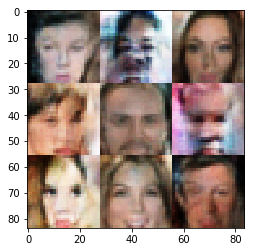

Epoch 8811/1... Discriminator Loss: 0.3944... Generator Loss: 2.8201
Epoch 8821/1... Discriminator Loss: 0.4360... Generator Loss: 1.7244
Epoch 8831/1... Discriminator Loss: 0.5793... Generator Loss: 1.5464
Epoch 8841/1... Discriminator Loss: 0.4777... Generator Loss: 1.6983
Epoch 8851/1... Discriminator Loss: 0.4311... Generator Loss: 1.4237
Epoch 8861/1... Discriminator Loss: 0.4174... Generator Loss: 1.4744
Epoch 8871/1... Discriminator Loss: 0.6266... Generator Loss: 1.1413
Epoch 8881/1... Discriminator Loss: 0.2555... Generator Loss: 2.2332
Epoch 8891/1... Discriminator Loss: 0.5231... Generator Loss: 1.4896
Epoch 8901/1... Discriminator Loss: 0.8329... Generator Loss: 0.7140


Epoch 8911/1... Discriminator Loss: 0.5103... Generator Loss: 1.1196
Epoch 8921/1... Discriminator Loss: 0.4657... Generator Loss: 2.3363
Epoch 8931/1... Discriminator Loss: 0.3999... Generator Loss: 1.8296
Epoch 8941/1... Discriminator Loss: 0.5346... Generator Loss: 1.1001
Epoch 8951/1... Discriminator Loss: 0.5469... Generator Loss: 1.5171
Epoch 8961/1... Discriminator Loss: 0.9699... Generator Loss: 0.6077
Epoch 8971/1... Discriminator Loss: 0.3455... Generator Loss: 1.7741
Epoch 8981/1... Discriminator Loss: 0.7582... Generator Loss: 1.0180
Epoch 8991/1... Discriminator Loss: 0.6867... Generator Loss: 0.9485
Epoch 9001/1... Discriminator Loss: 0.5005... Generator Loss: 1.3707


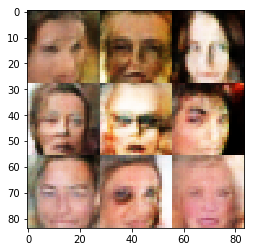

Epoch 9011/1... Discriminator Loss: 0.3869... Generator Loss: 2.5887
Epoch 9021/1... Discriminator Loss: 0.2372... Generator Loss: 3.1415
Epoch 9031/1... Discriminator Loss: 0.6515... Generator Loss: 1.5062
Epoch 9041/1... Discriminator Loss: 0.6013... Generator Loss: 1.2931
Epoch 9051/1... Discriminator Loss: 0.4551... Generator Loss: 1.4095
Epoch 9061/1... Discriminator Loss: 0.6756... Generator Loss: 0.9162
Epoch 9071/1... Discriminator Loss: 0.7690... Generator Loss: 0.8022
Epoch 9081/1... Discriminator Loss: 0.4297... Generator Loss: 2.4905
Epoch 9091/1... Discriminator Loss: 1.0136... Generator Loss: 0.6554
Epoch 9101/1... Discriminator Loss: 0.4001... Generator Loss: 1.4251


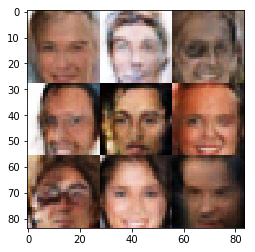

Epoch 9111/1... Discriminator Loss: 0.5691... Generator Loss: 1.4091
Epoch 9121/1... Discriminator Loss: 1.1035... Generator Loss: 0.5290
Epoch 9131/1... Discriminator Loss: 0.7891... Generator Loss: 0.8554
Epoch 9141/1... Discriminator Loss: 0.2728... Generator Loss: 1.9204
Epoch 9151/1... Discriminator Loss: 0.4965... Generator Loss: 1.4746
Epoch 9161/1... Discriminator Loss: 1.1831... Generator Loss: 0.5670
Epoch 9171/1... Discriminator Loss: 0.6833... Generator Loss: 0.9602
Epoch 9181/1... Discriminator Loss: 0.1935... Generator Loss: 2.5434
Epoch 9191/1... Discriminator Loss: 0.6545... Generator Loss: 1.0929
Epoch 9201/1... Discriminator Loss: 0.4771... Generator Loss: 1.3563


Epoch 9211/1... Discriminator Loss: 0.4991... Generator Loss: 1.5423
Epoch 9221/1... Discriminator Loss: 0.3904... Generator Loss: 1.6795
Epoch 9231/1... Discriminator Loss: 1.0151... Generator Loss: 0.5600
Epoch 9241/1... Discriminator Loss: 0.5509... Generator Loss: 1.2165
Epoch 9251/1... Discriminator Loss: 0.3765... Generator Loss: 1.4445
Epoch 9261/1... Discriminator Loss: 0.4419... Generator Loss: 1.7188
Epoch 9271/1... Discriminator Loss: 0.4323... Generator Loss: 1.8027
Epoch 9281/1... Discriminator Loss: 0.5451... Generator Loss: 1.2111
Epoch 9291/1... Discriminator Loss: 0.8360... Generator Loss: 0.7126
Epoch 9301/1... Discriminator Loss: 0.3879... Generator Loss: 1.8335


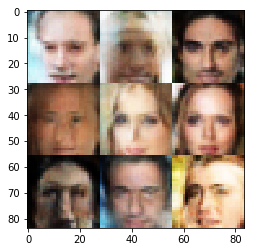

Epoch 9311/1... Discriminator Loss: 0.4791... Generator Loss: 1.2580
Epoch 9321/1... Discriminator Loss: 0.6060... Generator Loss: 1.0467
Epoch 9331/1... Discriminator Loss: 0.9649... Generator Loss: 0.7219
Epoch 9341/1... Discriminator Loss: 0.6951... Generator Loss: 1.0187
Epoch 9351/1... Discriminator Loss: 1.0090... Generator Loss: 0.6136
Epoch 9361/1... Discriminator Loss: 0.4536... Generator Loss: 1.6443
Epoch 9371/1... Discriminator Loss: 0.4204... Generator Loss: 1.3798
Epoch 9381/1... Discriminator Loss: 0.7518... Generator Loss: 1.0275
Epoch 9391/1... Discriminator Loss: 0.6615... Generator Loss: 1.1796
Epoch 9401/1... Discriminator Loss: 0.7284... Generator Loss: 0.9815


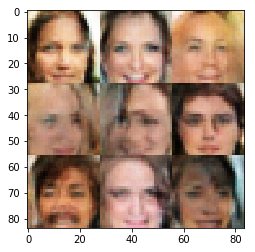

Epoch 9411/1... Discriminator Loss: 0.9084... Generator Loss: 0.6586
Epoch 9421/1... Discriminator Loss: 0.6301... Generator Loss: 0.9870
Epoch 9431/1... Discriminator Loss: 0.4591... Generator Loss: 1.8878
Epoch 9441/1... Discriminator Loss: 0.4726... Generator Loss: 1.3401
Epoch 9451/1... Discriminator Loss: 0.4733... Generator Loss: 1.4952
Epoch 9461/1... Discriminator Loss: 0.5426... Generator Loss: 1.1984
Epoch 9471/1... Discriminator Loss: 0.6495... Generator Loss: 1.0117
Epoch 9481/1... Discriminator Loss: 0.4965... Generator Loss: 1.3065
Epoch 9491/1... Discriminator Loss: 1.5071... Generator Loss: 0.3315
Epoch 9501/1... Discriminator Loss: 1.0233... Generator Loss: 0.6777


Epoch 9511/1... Discriminator Loss: 0.9652... Generator Loss: 0.5740
Epoch 9521/1... Discriminator Loss: 0.2958... Generator Loss: 2.3172
Epoch 9531/1... Discriminator Loss: 0.6206... Generator Loss: 1.0633
Epoch 9541/1... Discriminator Loss: 0.5669... Generator Loss: 1.3272
Epoch 9551/1... Discriminator Loss: 0.8174... Generator Loss: 0.8523
Epoch 9561/1... Discriminator Loss: 0.7597... Generator Loss: 0.7748
Epoch 9571/1... Discriminator Loss: 0.5870... Generator Loss: 1.1611
Epoch 9581/1... Discriminator Loss: 0.8117... Generator Loss: 0.7087
Epoch 9591/1... Discriminator Loss: 0.6549... Generator Loss: 1.0143
Epoch 9601/1... Discriminator Loss: 0.7402... Generator Loss: 0.8129


Epoch 9611/1... Discriminator Loss: 0.6521... Generator Loss: 1.1614
Epoch 9621/1... Discriminator Loss: 0.4547... Generator Loss: 1.2710
Epoch 9631/1... Discriminator Loss: 0.6254... Generator Loss: 1.1006
Epoch 9641/1... Discriminator Loss: 0.4424... Generator Loss: 1.5193
Epoch 9651/1... Discriminator Loss: 0.6945... Generator Loss: 0.9716
Epoch 9661/1... Discriminator Loss: 0.5682... Generator Loss: 1.0914
Epoch 9671/1... Discriminator Loss: 0.5441... Generator Loss: 1.1331
Epoch 9681/1... Discriminator Loss: 0.7092... Generator Loss: 0.9687
Epoch 9691/1... Discriminator Loss: 0.4767... Generator Loss: 1.6784
Epoch 9701/1... Discriminator Loss: 1.6574... Generator Loss: 0.3363


Epoch 9711/1... Discriminator Loss: 0.7251... Generator Loss: 0.9169
Epoch 9721/1... Discriminator Loss: 1.1701... Generator Loss: 0.4931
Epoch 9731/1... Discriminator Loss: 0.5247... Generator Loss: 1.6429
Epoch 9741/1... Discriminator Loss: 1.0198... Generator Loss: 0.5554
Epoch 9751/1... Discriminator Loss: 0.7063... Generator Loss: 1.2820
Epoch 9761/1... Discriminator Loss: 0.4312... Generator Loss: 1.2041
Epoch 9771/1... Discriminator Loss: 0.9272... Generator Loss: 0.6456
Epoch 9781/1... Discriminator Loss: 0.2977... Generator Loss: 1.5389
Epoch 9791/1... Discriminator Loss: 0.8962... Generator Loss: 0.6513
Epoch 9801/1... Discriminator Loss: 0.9456... Generator Loss: 0.6316


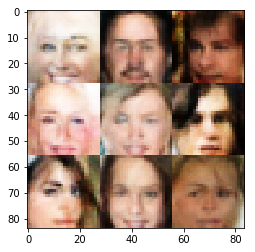

Epoch 9811/1... Discriminator Loss: 0.3607... Generator Loss: 2.8877
Epoch 9821/1... Discriminator Loss: 0.6489... Generator Loss: 0.8845
Epoch 9831/1... Discriminator Loss: 0.7832... Generator Loss: 0.9053
Epoch 9841/1... Discriminator Loss: 1.1210... Generator Loss: 0.5259
Epoch 9851/1... Discriminator Loss: 0.2191... Generator Loss: 1.9245
Epoch 9861/1... Discriminator Loss: 0.4210... Generator Loss: 1.6317
Epoch 9871/1... Discriminator Loss: 0.7532... Generator Loss: 0.8790
Epoch 9881/1... Discriminator Loss: 0.6914... Generator Loss: 0.8970
Epoch 9891/1... Discriminator Loss: 0.5572... Generator Loss: 1.1706
Epoch 9901/1... Discriminator Loss: 0.4186... Generator Loss: 1.4692


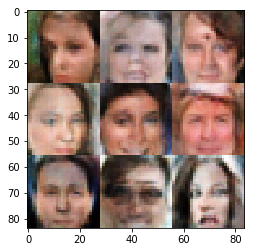

Epoch 9911/1... Discriminator Loss: 0.8711... Generator Loss: 0.6625
Epoch 9921/1... Discriminator Loss: 0.6963... Generator Loss: 0.8512
Epoch 9931/1... Discriminator Loss: 0.4892... Generator Loss: 1.3012
Epoch 9941/1... Discriminator Loss: 0.4357... Generator Loss: 1.7514
Epoch 9951/1... Discriminator Loss: 0.7361... Generator Loss: 0.8340
Epoch 9961/1... Discriminator Loss: 0.5357... Generator Loss: 1.6150
Epoch 9971/1... Discriminator Loss: 0.5814... Generator Loss: 1.5600
Epoch 9981/1... Discriminator Loss: 0.5251... Generator Loss: 1.1745
Epoch 9991/1... Discriminator Loss: 0.7739... Generator Loss: 0.9818
Epoch 10001/1... Discriminator Loss: 0.4316... Generator Loss: 1.7629


Epoch 10011/1... Discriminator Loss: 0.4711... Generator Loss: 1.2339
Epoch 10021/1... Discriminator Loss: 0.7739... Generator Loss: 0.8180
Epoch 10031/1... Discriminator Loss: 0.4115... Generator Loss: 1.5546
Epoch 10041/1... Discriminator Loss: 1.3809... Generator Loss: 0.4301
Epoch 10051/1... Discriminator Loss: 1.0538... Generator Loss: 0.5371
Epoch 10061/1... Discriminator Loss: 0.7727... Generator Loss: 2.6497
Epoch 10071/1... Discriminator Loss: 0.3400... Generator Loss: 2.3598
Epoch 10081/1... Discriminator Loss: 0.3078... Generator Loss: 2.0766
Epoch 10091/1... Discriminator Loss: 0.4095... Generator Loss: 1.6119
Epoch 10101/1... Discriminator Loss: 0.3283... Generator Loss: 2.7022


Epoch 10111/1... Discriminator Loss: 0.5818... Generator Loss: 1.0278
Epoch 10121/1... Discriminator Loss: 0.2340... Generator Loss: 2.3311
Epoch 10131/1... Discriminator Loss: 0.2754... Generator Loss: 2.0215
Epoch 10141/1... Discriminator Loss: 0.5034... Generator Loss: 1.1340
Epoch 10151/1... Discriminator Loss: 0.5011... Generator Loss: 1.3337
Epoch 10161/1... Discriminator Loss: 0.3906... Generator Loss: 1.5093
Epoch 10171/1... Discriminator Loss: 0.3675... Generator Loss: 1.7355
Epoch 10181/1... Discriminator Loss: 0.7125... Generator Loss: 1.4998
Epoch 10191/1... Discriminator Loss: 0.5159... Generator Loss: 1.1633
Epoch 10201/1... Discriminator Loss: 1.0770... Generator Loss: 0.6130


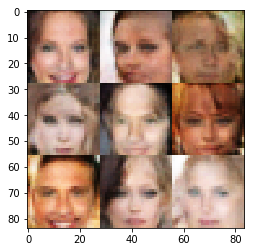

Epoch 10211/1... Discriminator Loss: 0.6402... Generator Loss: 0.9584
Epoch 10221/1... Discriminator Loss: 0.8802... Generator Loss: 0.6406
Epoch 10231/1... Discriminator Loss: 0.4955... Generator Loss: 1.3040
Epoch 10241/1... Discriminator Loss: 0.6507... Generator Loss: 1.0618
Epoch 10251/1... Discriminator Loss: 0.6940... Generator Loss: 0.9784
Epoch 10261/1... Discriminator Loss: 0.9863... Generator Loss: 0.7368
Epoch 10271/1... Discriminator Loss: 0.2025... Generator Loss: 2.2423
Epoch 10281/1... Discriminator Loss: 0.7954... Generator Loss: 1.5237
Epoch 10291/1... Discriminator Loss: 0.3637... Generator Loss: 1.8586
Epoch 10301/1... Discriminator Loss: 0.5425... Generator Loss: 1.2584


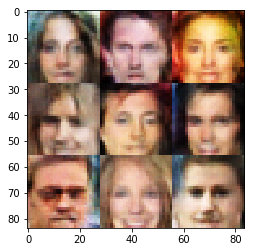

Epoch 10311/1... Discriminator Loss: 0.7118... Generator Loss: 1.0407
Epoch 10321/1... Discriminator Loss: 0.9346... Generator Loss: 0.7235
Epoch 10331/1... Discriminator Loss: 1.0115... Generator Loss: 0.6339
Epoch 10341/1... Discriminator Loss: 0.5827... Generator Loss: 1.7038
Epoch 10351/1... Discriminator Loss: 0.7726... Generator Loss: 0.8777
Epoch 10361/1... Discriminator Loss: 0.4381... Generator Loss: 1.8291
Epoch 10371/1... Discriminator Loss: 0.5523... Generator Loss: 1.0806
Epoch 10381/1... Discriminator Loss: 0.3570... Generator Loss: 1.6842
Epoch 10391/1... Discriminator Loss: 0.3031... Generator Loss: 2.1117
Epoch 10401/1... Discriminator Loss: 0.4625... Generator Loss: 1.3790


Epoch 10411/1... Discriminator Loss: 0.2750... Generator Loss: 1.7052
Epoch 10421/1... Discriminator Loss: 0.4731... Generator Loss: 1.3936
Epoch 10431/1... Discriminator Loss: 0.5727... Generator Loss: 1.2561
Epoch 10441/1... Discriminator Loss: 0.4107... Generator Loss: 1.3389
Epoch 10451/1... Discriminator Loss: 0.5105... Generator Loss: 1.3335
Epoch 10461/1... Discriminator Loss: 0.4552... Generator Loss: 1.3947
Epoch 10471/1... Discriminator Loss: 0.3638... Generator Loss: 1.8049
Epoch 10481/1... Discriminator Loss: 0.3855... Generator Loss: 1.6546
Epoch 10491/1... Discriminator Loss: 0.7069... Generator Loss: 0.8442
Epoch 10501/1... Discriminator Loss: 0.6130... Generator Loss: 2.2019


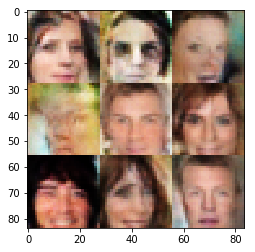

Epoch 10511/1... Discriminator Loss: 0.4054... Generator Loss: 1.7412
Epoch 10521/1... Discriminator Loss: 1.0020... Generator Loss: 0.5937
Epoch 10531/1... Discriminator Loss: 0.7754... Generator Loss: 1.3794
Epoch 10541/1... Discriminator Loss: 0.1253... Generator Loss: 2.6839
Epoch 10551/1... Discriminator Loss: 0.5796... Generator Loss: 1.0194
Epoch 10561/1... Discriminator Loss: 0.9900... Generator Loss: 0.9427
Epoch 10571/1... Discriminator Loss: 0.7995... Generator Loss: 0.8854
Epoch 10581/1... Discriminator Loss: 0.6807... Generator Loss: 0.9498
Epoch 10591/1... Discriminator Loss: 1.0213... Generator Loss: 0.6554
Epoch 10601/1... Discriminator Loss: 0.4203... Generator Loss: 1.8350


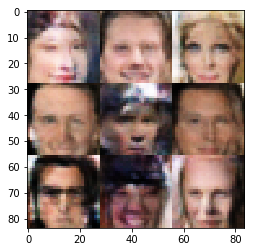

Epoch 10611/1... Discriminator Loss: 0.7336... Generator Loss: 0.9325
Epoch 10621/1... Discriminator Loss: 1.0351... Generator Loss: 0.5697
Epoch 10631/1... Discriminator Loss: 0.8372... Generator Loss: 0.6608
Epoch 10641/1... Discriminator Loss: 1.5333... Generator Loss: 0.3033
Epoch 10651/1... Discriminator Loss: 0.4888... Generator Loss: 1.5423
Epoch 10661/1... Discriminator Loss: 0.6268... Generator Loss: 0.8691
Epoch 10671/1... Discriminator Loss: 0.9856... Generator Loss: 0.7073
Epoch 10681/1... Discriminator Loss: 0.5673... Generator Loss: 1.7441
Epoch 10691/1... Discriminator Loss: 0.9544... Generator Loss: 0.6957
Epoch 10701/1... Discriminator Loss: 0.4655... Generator Loss: 1.4105


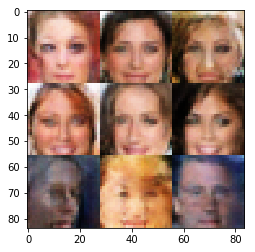

Epoch 10711/1... Discriminator Loss: 0.4035... Generator Loss: 1.4293
Epoch 10721/1... Discriminator Loss: 1.3938... Generator Loss: 0.3283
Epoch 10731/1... Discriminator Loss: 0.8430... Generator Loss: 0.9005
Epoch 10741/1... Discriminator Loss: 0.4272... Generator Loss: 1.6911
Epoch 10751/1... Discriminator Loss: 0.4732... Generator Loss: 1.5515
Epoch 10761/1... Discriminator Loss: 0.7318... Generator Loss: 0.8680
Epoch 10771/1... Discriminator Loss: 1.0084... Generator Loss: 0.7078
Epoch 10781/1... Discriminator Loss: 0.5449... Generator Loss: 1.7056
Epoch 10791/1... Discriminator Loss: 0.4843... Generator Loss: 1.7975
Epoch 10801/1... Discriminator Loss: 0.5565... Generator Loss: 1.3537


Epoch 10811/1... Discriminator Loss: 0.5641... Generator Loss: 1.4979
Epoch 10821/1... Discriminator Loss: 0.6071... Generator Loss: 1.1043
Epoch 10831/1... Discriminator Loss: 0.9702... Generator Loss: 0.7491
Epoch 10841/1... Discriminator Loss: 0.5180... Generator Loss: 1.8765
Epoch 10851/1... Discriminator Loss: 0.5871... Generator Loss: 1.0590
Epoch 10861/1... Discriminator Loss: 0.5857... Generator Loss: 1.2104
Epoch 10871/1... Discriminator Loss: 0.3718... Generator Loss: 1.8085
Epoch 10881/1... Discriminator Loss: 0.9933... Generator Loss: 0.5981
Epoch 10891/1... Discriminator Loss: 0.3073... Generator Loss: 1.5498
Epoch 10901/1... Discriminator Loss: 0.4449... Generator Loss: 1.4998


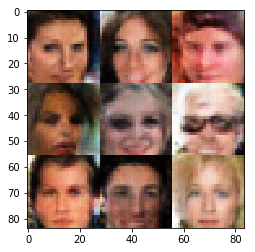

Epoch 10911/1... Discriminator Loss: 0.4334... Generator Loss: 1.6765
Epoch 10921/1... Discriminator Loss: 1.0254... Generator Loss: 0.7720
Epoch 10931/1... Discriminator Loss: 0.9303... Generator Loss: 0.7202
Epoch 10941/1... Discriminator Loss: 0.3186... Generator Loss: 1.6788
Epoch 10951/1... Discriminator Loss: 0.6078... Generator Loss: 1.0324
Epoch 10961/1... Discriminator Loss: 0.8985... Generator Loss: 0.6296
Epoch 10971/1... Discriminator Loss: 0.3090... Generator Loss: 1.6670
Epoch 10981/1... Discriminator Loss: 0.7047... Generator Loss: 1.0673
Epoch 10991/1... Discriminator Loss: 0.5311... Generator Loss: 1.2981
Epoch 11001/1... Discriminator Loss: 0.9445... Generator Loss: 0.7546


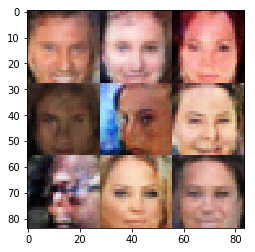

Epoch 11011/1... Discriminator Loss: 0.6402... Generator Loss: 1.1978
Epoch 11021/1... Discriminator Loss: 0.9922... Generator Loss: 0.6594
Epoch 11031/1... Discriminator Loss: 0.3661... Generator Loss: 1.3946
Epoch 11041/1... Discriminator Loss: 0.4597... Generator Loss: 1.7842
Epoch 11051/1... Discriminator Loss: 0.5327... Generator Loss: 1.1390
Epoch 11061/1... Discriminator Loss: 0.5918... Generator Loss: 1.5379
Epoch 11071/1... Discriminator Loss: 0.9176... Generator Loss: 0.8031
Epoch 11081/1... Discriminator Loss: 0.8066... Generator Loss: 0.8088
Epoch 11091/1... Discriminator Loss: 0.4427... Generator Loss: 1.4091
Epoch 11101/1... Discriminator Loss: 0.5062... Generator Loss: 1.2991


Epoch 11111/1... Discriminator Loss: 0.6182... Generator Loss: 0.9796
Epoch 11121/1... Discriminator Loss: 0.7340... Generator Loss: 1.1166
Epoch 11131/1... Discriminator Loss: 0.5895... Generator Loss: 1.0574
Epoch 11141/1... Discriminator Loss: 0.8951... Generator Loss: 0.7252
Epoch 11151/1... Discriminator Loss: 0.8005... Generator Loss: 0.7829
Epoch 11161/1... Discriminator Loss: 0.4909... Generator Loss: 1.6717
Epoch 11171/1... Discriminator Loss: 0.7847... Generator Loss: 0.7927
Epoch 11181/1... Discriminator Loss: 0.5713... Generator Loss: 1.2239
Epoch 11191/1... Discriminator Loss: 0.5080... Generator Loss: 1.3808
Epoch 11201/1... Discriminator Loss: 0.4366... Generator Loss: 1.4421


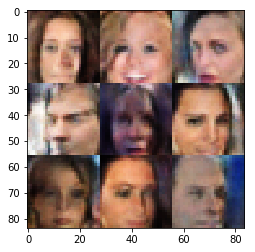

Epoch 11211/1... Discriminator Loss: 0.6571... Generator Loss: 1.1066
Epoch 11221/1... Discriminator Loss: 0.5630... Generator Loss: 1.1980
Epoch 11231/1... Discriminator Loss: 0.4792... Generator Loss: 1.2546
Epoch 11241/1... Discriminator Loss: 0.5627... Generator Loss: 1.1115
Epoch 11251/1... Discriminator Loss: 0.5632... Generator Loss: 1.2888
Epoch 11261/1... Discriminator Loss: 0.2884... Generator Loss: 2.0073
Epoch 11271/1... Discriminator Loss: 0.8425... Generator Loss: 0.7690
Epoch 11281/1... Discriminator Loss: 0.5713... Generator Loss: 1.2397
Epoch 11291/1... Discriminator Loss: 0.5742... Generator Loss: 1.4695
Epoch 11301/1... Discriminator Loss: 0.8954... Generator Loss: 0.7727


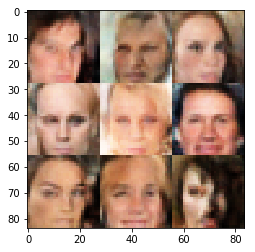

Epoch 11311/1... Discriminator Loss: 0.4927... Generator Loss: 1.1949
Epoch 11321/1... Discriminator Loss: 0.4112... Generator Loss: 1.3190
Epoch 11331/1... Discriminator Loss: 0.5061... Generator Loss: 1.5577
Epoch 11341/1... Discriminator Loss: 0.4763... Generator Loss: 1.4903
Epoch 11351/1... Discriminator Loss: 0.4194... Generator Loss: 2.0573
Epoch 11361/1... Discriminator Loss: 0.7821... Generator Loss: 0.8075
Epoch 11371/1... Discriminator Loss: 1.1235... Generator Loss: 0.6770
Epoch 11381/1... Discriminator Loss: 0.6306... Generator Loss: 1.1170
Epoch 11391/1... Discriminator Loss: 0.5663... Generator Loss: 1.5885
Epoch 11401/1... Discriminator Loss: 0.4198... Generator Loss: 1.4528


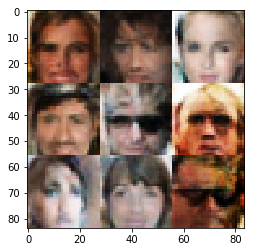

Epoch 11411/1... Discriminator Loss: 0.5369... Generator Loss: 1.4769
Epoch 11421/1... Discriminator Loss: 0.4929... Generator Loss: 1.4118
Epoch 11431/1... Discriminator Loss: 0.5864... Generator Loss: 1.6303
Epoch 11441/1... Discriminator Loss: 1.1177... Generator Loss: 0.4823
Epoch 11451/1... Discriminator Loss: 0.8895... Generator Loss: 0.7423
Epoch 11461/1... Discriminator Loss: 0.7213... Generator Loss: 0.8388
Epoch 11471/1... Discriminator Loss: 0.4793... Generator Loss: 1.6849
Epoch 11481/1... Discriminator Loss: 1.5934... Generator Loss: 0.3108
Epoch 11491/1... Discriminator Loss: 0.5175... Generator Loss: 1.7515
Epoch 11501/1... Discriminator Loss: 1.0047... Generator Loss: 0.6545


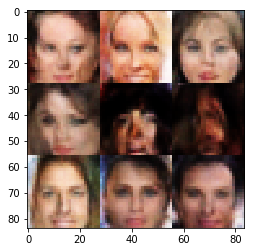

Epoch 11511/1... Discriminator Loss: 0.8514... Generator Loss: 0.8768
Epoch 11521/1... Discriminator Loss: 0.5296... Generator Loss: 1.1806
Epoch 11531/1... Discriminator Loss: 0.7475... Generator Loss: 0.7625
Epoch 11541/1... Discriminator Loss: 0.5724... Generator Loss: 1.2185
Epoch 11551/1... Discriminator Loss: 1.0501... Generator Loss: 0.5367
Epoch 11561/1... Discriminator Loss: 0.6578... Generator Loss: 1.2500
Epoch 11571/1... Discriminator Loss: 0.6008... Generator Loss: 1.0073
Epoch 11581/1... Discriminator Loss: 0.7175... Generator Loss: 0.7931
Epoch 11591/1... Discriminator Loss: 0.3222... Generator Loss: 1.9626
Epoch 11601/1... Discriminator Loss: 0.7687... Generator Loss: 0.8559


Epoch 11611/1... Discriminator Loss: 0.8426... Generator Loss: 0.7788
Epoch 11621/1... Discriminator Loss: 1.3715... Generator Loss: 0.3768
Epoch 11631/1... Discriminator Loss: 0.6713... Generator Loss: 1.2643
Epoch 11641/1... Discriminator Loss: 0.9976... Generator Loss: 0.6260
Epoch 11651/1... Discriminator Loss: 0.5816... Generator Loss: 1.3491
Epoch 11661/1... Discriminator Loss: 0.5744... Generator Loss: 1.0334
Epoch 11671/1... Discriminator Loss: 0.1765... Generator Loss: 3.0392
Epoch 11681/1... Discriminator Loss: 0.5784... Generator Loss: 1.1209
Epoch 11691/1... Discriminator Loss: 0.5027... Generator Loss: 1.4427
Epoch 11701/1... Discriminator Loss: 0.6430... Generator Loss: 1.0504


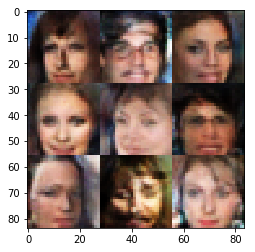

Epoch 11711/1... Discriminator Loss: 0.4587... Generator Loss: 1.5106
Epoch 11721/1... Discriminator Loss: 0.5932... Generator Loss: 1.1092
Epoch 11731/1... Discriminator Loss: 0.6937... Generator Loss: 0.9188
Epoch 11741/1... Discriminator Loss: 0.6413... Generator Loss: 1.1849
Epoch 11751/1... Discriminator Loss: 0.3239... Generator Loss: 1.9515
Epoch 11761/1... Discriminator Loss: 0.4758... Generator Loss: 1.4071
Epoch 11771/1... Discriminator Loss: 0.5566... Generator Loss: 1.3501
Epoch 11781/1... Discriminator Loss: 0.4120... Generator Loss: 1.5864
Epoch 11791/1... Discriminator Loss: 0.6007... Generator Loss: 1.0823
Epoch 11801/1... Discriminator Loss: 0.7783... Generator Loss: 1.0683


Epoch 11811/1... Discriminator Loss: 0.3315... Generator Loss: 2.2215
Epoch 11821/1... Discriminator Loss: 0.5806... Generator Loss: 1.1341
Epoch 11831/1... Discriminator Loss: 0.8478... Generator Loss: 0.7489
Epoch 11841/1... Discriminator Loss: 0.4483... Generator Loss: 1.3752
Epoch 11851/1... Discriminator Loss: 0.5490... Generator Loss: 1.3855
Epoch 11861/1... Discriminator Loss: 0.3595... Generator Loss: 1.6400
Epoch 11871/1... Discriminator Loss: 0.5614... Generator Loss: 1.5922
Epoch 11881/1... Discriminator Loss: 0.8368... Generator Loss: 0.8369
Epoch 11891/1... Discriminator Loss: 0.6530... Generator Loss: 1.1980
Epoch 11901/1... Discriminator Loss: 0.8931... Generator Loss: 1.5732


Epoch 11911/1... Discriminator Loss: 0.6571... Generator Loss: 1.0624
Epoch 11921/1... Discriminator Loss: 0.4073... Generator Loss: 1.4775
Epoch 11931/1... Discriminator Loss: 0.6940... Generator Loss: 0.9484
Epoch 11941/1... Discriminator Loss: 0.6274... Generator Loss: 1.0076
Epoch 11951/1... Discriminator Loss: 0.5003... Generator Loss: 1.3697
Epoch 11961/1... Discriminator Loss: 0.6596... Generator Loss: 0.8865
Epoch 11971/1... Discriminator Loss: 0.6622... Generator Loss: 1.0141
Epoch 11981/1... Discriminator Loss: 0.4959... Generator Loss: 1.5138
Epoch 11991/1... Discriminator Loss: 0.4436... Generator Loss: 1.3992
Epoch 12001/1... Discriminator Loss: 0.6009... Generator Loss: 1.5689


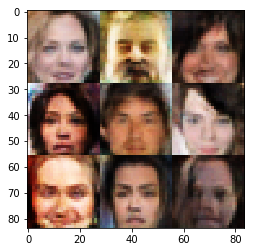

Epoch 12011/1... Discriminator Loss: 0.6849... Generator Loss: 0.9705
Epoch 12021/1... Discriminator Loss: 0.5149... Generator Loss: 1.9438
Epoch 12031/1... Discriminator Loss: 0.5367... Generator Loss: 1.2192
Epoch 12041/1... Discriminator Loss: 0.7343... Generator Loss: 1.0596
Epoch 12051/1... Discriminator Loss: 0.7801... Generator Loss: 0.7938
Epoch 12061/1... Discriminator Loss: 0.4190... Generator Loss: 1.4824
Epoch 12071/1... Discriminator Loss: 0.8021... Generator Loss: 0.8217
Epoch 12081/1... Discriminator Loss: 0.5141... Generator Loss: 1.2348
Epoch 12091/1... Discriminator Loss: 0.9319... Generator Loss: 0.7091
Epoch 12101/1... Discriminator Loss: 0.6437... Generator Loss: 1.1174


Epoch 12111/1... Discriminator Loss: 0.6538... Generator Loss: 1.2947
Epoch 12121/1... Discriminator Loss: 0.4994... Generator Loss: 1.3656
Epoch 12131/1... Discriminator Loss: 0.5560... Generator Loss: 1.3314
Epoch 12141/1... Discriminator Loss: 0.4503... Generator Loss: 1.2195
Epoch 12151/1... Discriminator Loss: 0.3736... Generator Loss: 1.6955
Epoch 12161/1... Discriminator Loss: 0.8965... Generator Loss: 1.3499
Epoch 12171/1... Discriminator Loss: 0.7323... Generator Loss: 1.1743
Epoch 12181/1... Discriminator Loss: 0.7540... Generator Loss: 0.7971
Epoch 12191/1... Discriminator Loss: 0.8562... Generator Loss: 0.6999
Epoch 12201/1... Discriminator Loss: 0.5294... Generator Loss: 1.3060


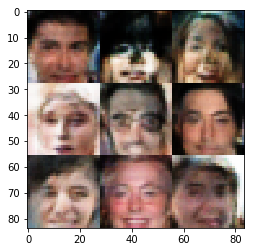

Epoch 12211/1... Discriminator Loss: 0.5605... Generator Loss: 1.1631
Epoch 12221/1... Discriminator Loss: 0.6886... Generator Loss: 0.9216
Epoch 12231/1... Discriminator Loss: 0.5134... Generator Loss: 1.5494
Epoch 12241/1... Discriminator Loss: 0.4450... Generator Loss: 1.4292
Epoch 12251/1... Discriminator Loss: 0.4807... Generator Loss: 1.3534
Epoch 12261/1... Discriminator Loss: 0.3853... Generator Loss: 1.9480
Epoch 12271/1... Discriminator Loss: 0.6470... Generator Loss: 0.9966
Epoch 12281/1... Discriminator Loss: 0.5743... Generator Loss: 1.0188
Epoch 12291/1... Discriminator Loss: 0.9054... Generator Loss: 0.7268
Epoch 12301/1... Discriminator Loss: 0.5581... Generator Loss: 1.4781


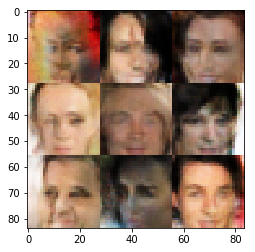

Epoch 12311/1... Discriminator Loss: 0.7165... Generator Loss: 1.0290
Epoch 12321/1... Discriminator Loss: 0.3519... Generator Loss: 1.8206
Epoch 12331/1... Discriminator Loss: 0.7694... Generator Loss: 0.7833
Epoch 12341/1... Discriminator Loss: 0.9970... Generator Loss: 0.5622
Epoch 12351/1... Discriminator Loss: 0.6384... Generator Loss: 1.2841
Epoch 12361/1... Discriminator Loss: 0.3464... Generator Loss: 1.5375
Epoch 12371/1... Discriminator Loss: 0.7752... Generator Loss: 0.8884
Epoch 12381/1... Discriminator Loss: 0.2443... Generator Loss: 1.9472
Epoch 12391/1... Discriminator Loss: 0.4059... Generator Loss: 1.3931
Epoch 12401/1... Discriminator Loss: 0.4918... Generator Loss: 1.2383


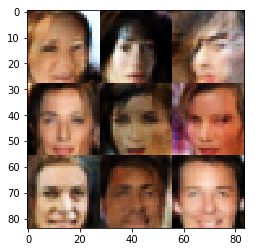

Epoch 12411/1... Discriminator Loss: 0.5720... Generator Loss: 1.0093
Epoch 12421/1... Discriminator Loss: 0.7328... Generator Loss: 0.9432
Epoch 12431/1... Discriminator Loss: 0.3915... Generator Loss: 1.5925
Epoch 12441/1... Discriminator Loss: 0.8821... Generator Loss: 0.7080
Epoch 12451/1... Discriminator Loss: 0.4874... Generator Loss: 1.5218
Epoch 12461/1... Discriminator Loss: 0.5995... Generator Loss: 1.2253
Epoch 12471/1... Discriminator Loss: 0.8598... Generator Loss: 0.8911
Epoch 12481/1... Discriminator Loss: 0.1850... Generator Loss: 2.4127
Epoch 12491/1... Discriminator Loss: 0.5271... Generator Loss: 1.5970
Epoch 12501/1... Discriminator Loss: 0.4339... Generator Loss: 1.9597


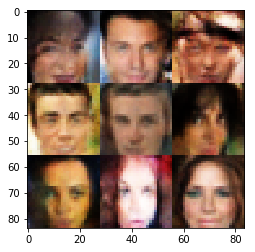

Epoch 12511/1... Discriminator Loss: 0.6723... Generator Loss: 0.8916
Epoch 12521/1... Discriminator Loss: 0.5974... Generator Loss: 1.0336
Epoch 12531/1... Discriminator Loss: 0.5088... Generator Loss: 1.2055
Epoch 12541/1... Discriminator Loss: 0.7205... Generator Loss: 0.9767
Epoch 12551/1... Discriminator Loss: 0.6453... Generator Loss: 0.8816
Epoch 12561/1... Discriminator Loss: 0.7773... Generator Loss: 0.8161
Epoch 12571/1... Discriminator Loss: 0.4195... Generator Loss: 1.4227
Epoch 12581/1... Discriminator Loss: 0.8391... Generator Loss: 0.7250
Epoch 12591/1... Discriminator Loss: 0.5588... Generator Loss: 1.2000
Epoch 12601/1... Discriminator Loss: 0.6189... Generator Loss: 1.0796


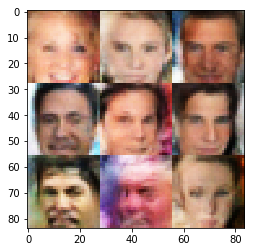

Epoch 12611/1... Discriminator Loss: 0.4026... Generator Loss: 1.5031
Epoch 12621/1... Discriminator Loss: 0.5098... Generator Loss: 1.2732
Epoch 12631/1... Discriminator Loss: 0.8663... Generator Loss: 0.7074
Epoch 12641/1... Discriminator Loss: 0.9321... Generator Loss: 0.6507
Epoch 12651/1... Discriminator Loss: 0.4815... Generator Loss: 1.2969
Epoch 12661/1... Discriminator Loss: 0.5169... Generator Loss: 1.1299


In [251]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。